# Solution to ADM-Homework 2
*by Vianney, Francesco, Onur Ozan and Daniel*

In [ ]:
datadir = None
# if working on colab import
try:
    from google.colab import drive
    drive.mount('/content/drive')
    datadir = "cloud"
    %run functions.py
    %run processing.py
    %run config.json
except Exception as e:
    print(e)
    datadir = "harddrive"
import functions
import processing
data_path = functions.get_from_config(datadir)
processing.initialize_processing_parameters_from_config()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


## Research questions [RQs]
### [RQ1]

In [5]:
# Authors

df_author = pd.read_json('lighter_authors.json',lines= True)
df_author.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [7]:
# Books

df_books = pd.read_json(r'lighter_books.json', lines=True, nrows=150000)

# Dropping the collumns we will not use to minimize the dataset.

columns_to_drop = ['isbn', 'isbn13', 'asin', 'edition_information', 'publisher', 'series_id', 'series_name', 'series_position', 'description', 'shelves']

df_books.drop(columns=columns_to_drop, inplace=True)
df_books = df_books[df_books['title'].notna()]
df_books = df_books[df_books['ratings_count'] >= 0]
df_books = df_books[df_books['text_reviews_count'] >= 0]

# convert 'num_pages' to integer, replacing empty strings with NaN
df_books['num_pages'] = df_books['num_pages'].replace('', np.nan).astype(float)

# filter out rows with 'num_pages' less than 0
df_books = df_books[df_books['num_pages'] >= 0]

# print information about the 'df_books' DataFrame
print(df_books.head())

   id                                              title  \
0   2  Harry Potter and the Order of the Phoenix (Har...   
1   3  Harry Potter and the Sorcerer's Stone (Harry P...   
2   4  Harry Potter and the Chamber of Secrets (Harry...   
3   5  Harry Potter and the Prisoner of Azkaban (Harr...   
4   6  Harry Potter and the Goblet of Fire (Harry Pot...   

                                             authors   author_name  author_id  \
0  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
1  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
2                                               None  J.K. Rowling    1077326   
3  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   
4  [{'id': '1077326', 'name': 'J.K. Rowling', 'ro...  J.K. Rowling    1077326   

   work_id language  average_rating  \
0  2809203      eng            4.50   
1  4640799      eng            4.48   
2  6231171      eng            4.43

In [8]:
# Let's see which collumns we have to avoid making mistakes in the future
print(df_books.columns)

Index(['id', 'title', 'authors', 'author_name', 'author_id', 'work_id',
       'language', 'average_rating', 'rating_dist', 'ratings_count',
       'text_reviews_count', 'publication_date', 'original_publication_date',
       'format', 'image_url', 'num_pages'],
      dtype='object')


### [RQ2] 
Let’s finally dig into this vast dataset, retrieving some vital information:

1. Plot the number of books for each author in descending order.
2. Which book has the highest number of reviews?
3. Which are the top ten and ten worst books concerning the average score?
4. Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed 5. 5. throughout our virtual library.
5. How many books have more than 250 pages?
6. Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

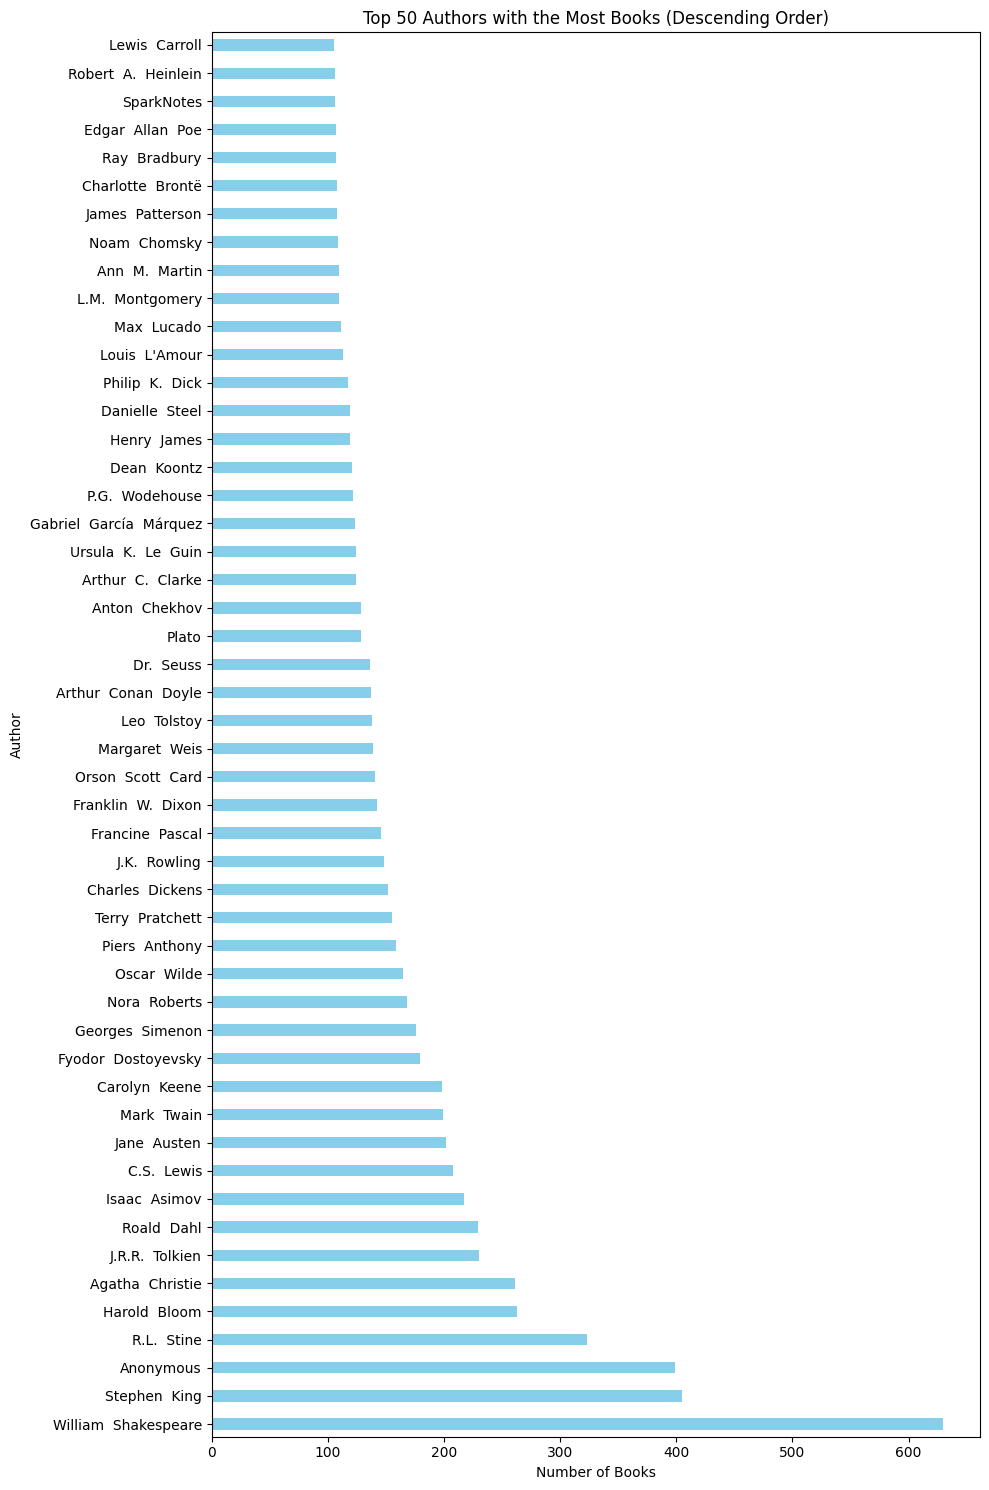

In [9]:
#RQ 2.1
author_counts = df_books['author_name'].value_counts()
# When we list the number of books by all authors, the graph becomes unreadable due to the large number of authors, so I limited the number of authors to 50. 
top_50_authors = author_counts.head(50)

top_50_authors.index = [author.replace(' ', '  ') for author in top_50_authors.index]
bar_width = 0.4 

plt.figure(figsize=(10, 15))

ax = top_50_authors.plot(kind='barh', color='skyblue', width=bar_width)
ax.set_title('Top 50 Authors with the Most Books (Descending Order)')
ax.set_xlabel('Number of Books')
ax.set_ylabel('Author')
plt.tight_layout()
plt.show()


In [10]:
#RQ 2.2

most_reviewed_books = df_books.nlargest(5, 'ratings_count')
print("Top 5 Most Reviewed Books:")
print(most_reviewed_books[['title', 'ratings_count']])

best_reviewed_books = df_books.nlargest(5, 'average_rating')
print("\nTop 5 Best Reviewed Books:")
print(best_reviewed_books[['title', 'average_rating']])

Top 5 Most Reviewed Books:
                                                   title  ratings_count
1      Harry Potter and the Sorcerer's Stone (Harry P...        7377351
2089   Harry Potter Y La Piedra Filosofal (Harry Pott...        7376804
2653            Harry Potter and the Philosopher's Stone        7376804
30984  Harry Potter and the Philosopher's Stone (Harr...        7371859
30999                 Harrius Potter et Philosophi Lapis        7371859

Top 5 Best Reviewed Books:
                                                  title  average_rating
653                                          Bernie Mac             5.0
671   Delaware 1638-1776 (Voices from Colonial America)             5.0
721   Simply Italian: 100 Easy-To-Make, Zesty, Satis...             5.0
762                                    Rudolph Giuliani             5.0
1101           Singers, Heroes, and Gods in the Odyssey             5.0


In [11]:
#RQ 2.3

# Sort the DataFrame by 'average_rating' in descending order (top 10 best)
top_10_best_books = df_books.sort_values(by='average_rating', ascending=False).head(10)

# Sort the DataFrame by 'average_rating' in ascending order (top 10 worst)
top_10_worst_books = df_books.sort_values(by='average_rating', ascending=True).head(10)

# Display the top 10 best books
print("Top 10 Best Books:")
print(top_10_best_books[['title', 'authors', 'average_rating']])

# Display the top 10 worst books
print("\nTop 10 Worst Books:")
print(top_10_worst_books[['title', 'authors', 'average_rating']])


Top 10 Best Books:
                                                    title  \
87861   Selected Works of Jawaharlal Nehru, 2nd Series...   
38593                   Mean Old Mickle & Smack-Biff-Thud   
89223                                  The Magpie's Story   
17160   Sermons, Newly Discovered (Works of Saint Augu...   
116042           Birds of Prey: A Look at Daytime Raptors   
50338      Economic Development and the Division of Labor   
129196               Yr Hen Iaith: Studies in Early Welsh   
27251   Orville And Wilbur Wright: Two Brothers, One D...   
88921                                         James Welch   
129444                         Get Sad When Somebody Dies   

                                                  authors  average_rating  
87861   [{'id': '89095', 'name': 'Jawaharlal Nehru', '...             5.0  
38593                                                None             5.0  
89223   [{'id': '35085', 'name': 'Nick Butterworth', '...             5.0  
17160

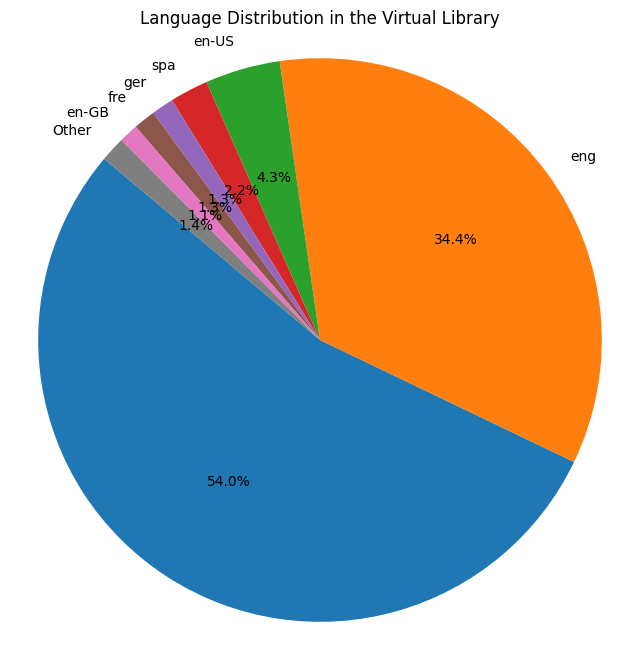

In [12]:
#RQ 2.4
language_counts = df_books['language'].value_counts()

# Calculate the total count of books
total_books = len(df_books)

# Calculate the threshold count (1% of the total)
threshold = 0.01 * total_books

# Filter out languages below the threshold and count them as "Other"
other_count = language_counts[language_counts < threshold].sum()
language_counts = language_counts[language_counts >= threshold]
language_counts['Other'] = other_count

# Create a pie chart to summarize language distribution
plt.figure(figsize=(8, 8))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution in the Virtual Library')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
#RQ 2.5
books_with_more_than_250_pages = df_books[df_books['num_pages'] > 250]
num_books_with_more_than_250_pages = len(books_with_more_than_250_pages)

print(f'The number of books with more than 250 pages is: {num_books_with_more_than_250_pages}')


The number of books with more than 250 pages is: 59799


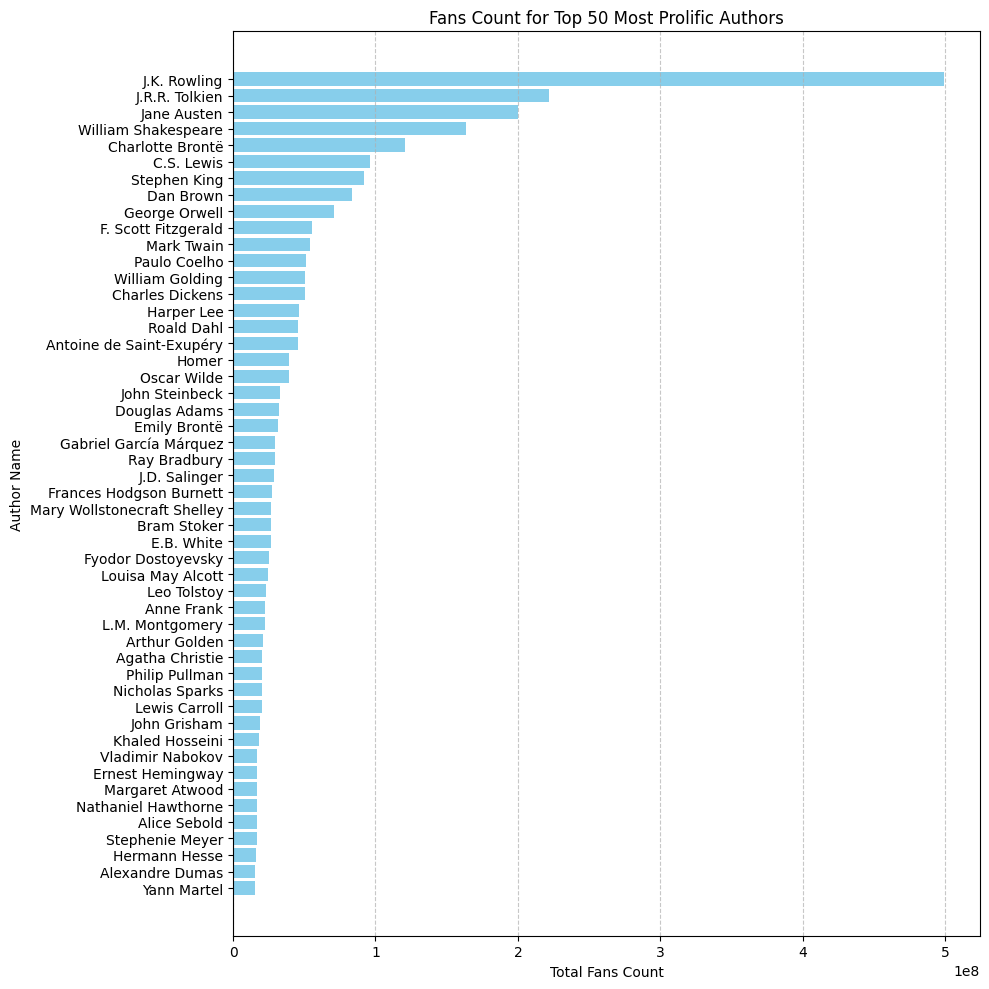

In [14]:
#RQ 2.6
author_fans_counts = df_books.groupby('author_name')['ratings_count'].sum()

# Select the top 50 authors with the most total fans
top_50_authors = author_fans_counts.nlargest(50)

# Filter the dataset to include only books by the top 50 authors
books_by_top_authors = df_books[df_books['author_name'].isin(top_50_authors.index)]

# Create a bar plot to display the author's name and their total fans count
plt.figure(figsize=(10, 10))
plt.barh(top_50_authors.index, top_50_authors.values, color='skyblue')
plt.title('Fans Count for Top 50 Most Prolific Authors')
plt.xlabel('Total Fans Count')
plt.ylabel('Author Name')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### [RQ3] 

Let’s have a historical look at the dataset!

1. Write a function that takes as input a year and returns as output the following information:

        The number of books published that year.

        The total number of pages written that year.

        The most prolific month of that year.

        The longest book written that year.

   

3. Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

4. Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

In [2]:
# In order to avoid problems in terms of performance and visualization, we put range parameter in the codes. By removing this parameter, the same process can be applied for the whole dataset. 
# There is an extra work we did without range restriction below.

In [16]:
#RQ3 Human Code

# convert publication_date column to datetime format with an explicit format
df_books['publication_date'] = pd.to_datetime(df_books['publication_date'], format='%Y-%m-%d', errors='coerce')

def year_summary(year):
    
    # books published in the specified year
    year_books = df_books[df_books['publication_date'].dt.year == year]

    # the number of books published that year
    num_books_published = len(year_books)

    # number of pages written that year
    total_pages_written = year_books['num_pages'].sum()

    # group books by month and count the number of books published in each month
    month_counts = year_books['publication_date'].dt.month.value_counts()
    most_prolific_month = month_counts.idxmax()

    # longest book written that year
    longest_book = year_books.loc[year_books['num_pages'].idxmax()]

    return {
        'Year': year,
        'Number of Books Published': num_books_published,
        'Total Pages Written': total_pages_written,
        'Most Prolific Month': most_prolific_month,
        'Longest Book Title': longest_book['title'],
        'Longest Book Author': longest_book['author_name'],
        'Longest Book Pages': longest_book['num_pages']
    }

# create a DataFrame for the years you want to analyze (e.g., from 2010 to 2020)
years = list(range(2010, 2021))
year_summaries = [year_summary(year) for year in years]
year_summary_df = pd.DataFrame(year_summaries)

# show the head and tail of the DataFrame
print("Head of the DataFrame (first ten years):")
print(year_summary_df.head(10))
print("\nTail of the DataFrame (last ten years):")
print(year_summary_df.tail(10))


Head of the DataFrame (first ten years):
   Year  Number of Books Published  Total Pages Written  Most Prolific Month  \
0  2010                        324              87326.0                    1   
1  2011                        249              72994.0                   11   
2  2012                        146              42959.0                    1   
3  2013                         99              27776.0                    4   
4  2014                         88              20235.0                    1   
5  2015                        101              24700.0                    2   
6  2016                         65              18371.0                   12   
7  2017                         39              12816.0                    5   
8  2018                         44              12624.0                    2   
9  2019                         29               6629.0                    5   

                                  Longest Book Title    Longest Book Author  \

In [17]:
#RQ3 GPT Code

def year_summary(year):
    year_books = df_books[df_books['publication_date'].dt.year == year]
    num_books = len(year_books)
    total_pages = year_books['num_pages'].sum()
    month_counts = year_books['publication_date'].dt.month.value_counts()
    most_prolific_month = month_counts.idxmax()
    longest_book = year_books.loc[year_books['num_pages'].idxmax()]
    
    return year, num_books, total_pages, most_prolific_month, longest_book['title'], longest_book['author_name'], longest_book['num_pages']

years = list(range(2010, 2021))
year_summary_data = [year_summary(year) for year in years]
year_summary_df = pd.DataFrame(year_summary_data, columns=['Year', 'Number of Books Published', 'Total Pages Written', 'Most Prolific Month', 'Longest Book Title', 'Longest Book Author', 'Longest Book Pages'])

print("Head of the DataFrame (first ten years):")
print(year_summary_df.head(10))
print("\nTail of the DataFrame (last ten years):")
print(year_summary_df.tail(10))


Head of the DataFrame (first ten years):
   Year  Number of Books Published  Total Pages Written  Most Prolific Month  \
0  2010                        324              87326.0                    1   
1  2011                        249              72994.0                   11   
2  2012                        146              42959.0                    1   
3  2013                         99              27776.0                    4   
4  2014                         88              20235.0                    1   
5  2015                        101              24700.0                    2   
6  2016                         65              18371.0                   12   
7  2017                         39              12816.0                    5   
8  2018                         44              12624.0                    2   
9  2019                         29               6629.0                    5   

                                  Longest Book Title    Longest Book Author  \

In [ ]:
#Differences of these two codes.

#The first code uses a separate function year_summary to calculate the year's summary and then iterates through the list of years to collect the data.

#The second code combines the calculation and data collection directly within a list comprehension.

#The first code specifies column names when creating the DataFrame using the columns parameter.

#The second code defines column names directly within the list comprehension, which makes it slightly less readable.

In [18]:
#Something Extra

df_books['publication_date'] = pd.to_datetime(df_books['publication_date'], format='%Y-%m-%d', errors='coerce')

def year_summary(year):
    """
    Calculate book summaries for a specific year.

    Args:
        year (int): The year.

    Returns:
        dict: A dictionary containing the year's summary information.
    """
    # Books published in the specified year
    year_books = df_books[df_books['publication_date'].dt.year == year]

    # Number of books published in that year
    num_books_published = len(year_books)

    # Total pages written in that year
    total_pages_written = year_books['num_pages'].sum()

    # Count the number of books published in each month by grouping books by month
    month_counts = year_books['publication_date'].dt.month.value_counts()

    most_prolific_month = month_counts.idxmax() if not month_counts.empty else None

    # Longest book written in that year
    longest_book = year_books.loc[year_books['num_pages'].idxmax()] if not year_books.empty else None

    return {
        'Year': year,
        'Number of Books Published': num_books_published,
        'Total Pages Written': total_pages_written,
        'Most Prolific Month': most_prolific_month,
        'Longest Book Title': longest_book['title'] if longest_book is not None else None,
        'Longest Book Author': longest_book['author_name'] if longest_book is not None else None,
        'Longest Book Pages': longest_book['num_pages'] if longest_book is not None else None
    }

# Get all unique years from the DataFrame
all_years = df_books['publication_date'].dt.year.unique()

# Calculate year summaries for all years
year_summaries = [year_summary(year) for year in all_years]

# Create a DataFrame containing the summaries
year_summary_df = pd.DataFrame(year_summaries)

# Sort the DataFrame by the 'Year' column in ascending order
year_summary_df = year_summary_df.sort_values(by='Year')

# Select the newest 10 years and the oldest 10 years for display
head_table = year_summary_df.tail(10)
tail_table = year_summary_df.head(10)

# Display the newest 10 years table
print("Newest 10 Years:")
print(head_table)

# Display the oldest 10 years table
print("\nOldest 10 Years:")
print(tail_table)


Newest 10 Years:
       Year  Number of Books Published  Total Pages Written  \
45   2013.0                         99              27776.0   
42   2014.0                         88              20235.0   
51   2015.0                        101              24700.0   
72   2016.0                         65              18371.0   
71   2017.0                         39              12816.0   
81   2018.0                         44              12624.0   
48   2019.0                         29               6629.0   
79   2020.0                         22               7347.0   
104  2021.0                          2                772.0   
0       NaN                          0                  0.0   

     Most Prolific Month                                 Longest Book Title  \
45                   4.0       Chess: 5334 Problems, Combinations and Games   
42                   1.0  Business Cycles: A Theoretical, Historical, an...   
51                   2.0    The History of the Russi

## [RQ4] 
Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

 - You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

 - Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

 - What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

 - What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

-------------------------------------------------------------------------------------------------------------------------------


- You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?
 
 If there is any eponymous (different authors who have precisely the same name) in the author's dataset we can check author's id and author's name and see if there are no mismatching.


-------------------------------------------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

df_author = pd.read_json('lighter_authors.json',lines= True)

# filter columns we're interested in
columns_to_keep = ['id', 'name']
df = df_author[columns_to_keep]

# Check for duplicates in the 'name' column
duplicates = df[df['name'].duplicated(keep=False)]

# filter duplicates and keep only those that doesn't have the same id
filtered_duplicates = duplicates[~duplicates.duplicated(subset='id', keep=False)]

# Sort the 'Data' column by alphabetical order
filtered_duplicates = filtered_duplicates.sort_values(by='name')

print("The eponymes are :")
print(filtered_duplicates)

The eponymes are :
              id               name
290533   8550578     Boris Zakhoder
175092  20971326     Boris Zakhoder
175811  21011400    Caroline Miller
27836     156110    Caroline Miller
35188     220670  Catherine   Jones
...          ...                ...
228145   6525370      Yordan Yovkov
171064  20862875          محمد نجيب
134763   2864244          محمد نجيب
224789   6456544              小野不由美
289074   8472533              小野不由美

[74 rows x 2 columns]


 - Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

In [ ]:
import pandas as pd

def create_author_book_dictionary():
    author_book_dict = {}
    data = pd.read_json('lighter_books.json', lines=True, nrows=1000)

    for index, row in data.iterrows():
        author_id = row['author_id']
        book_title = row['title']

        # Check if the author ID has already been registered and append the book title
        if author_id in author_book_dict:
            author_book_dict[author_id].append(book_title)
        else:
            author_book_dict[author_id] = [book_title]

    return author_book_dict

result = create_author_book_dictionary()
# Print the dictionary or do further processing
print(result)


{1077326: ['Harry Potter and the Order of the Phoenix (Harry Potter, #5)', "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)', 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)', 'Harry Potter and the Goblet of Fire (Harry Potter, #4)', 'The Harry Potter Collection (Harry Potter, #1-6)', 'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)', 'Harry Potter Collection (Harry Potter, #1-6)'], 4: ["The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy, #1-5)", "The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1-5)", "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Hitchhiker's Guide to the Galaxy: Quandary Phase (Hitchhiker's Guide: Radio


 - What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

In [ ]:
#store simultaneously the 20 best rating of books and their title then from this list do the same operation as below
import pandas as pd

# Create a DataFrame
df = pd.read_json('lighter_books.json', lines=True, nrows=10000)

# Sort the DataFrame by the 'Rating' column in descending order
df_sorted = df.sort_values(by='average_rating', ascending=False)

# Select the top 20 best-rated books
top_20_books = df_sorted.head(20)

# Initialize variables to track the book with the greatest number of characters
max_length = 0
max_length_title = None
max_length2 = 0
max_length_title2 = None

# Iterate through the top 20 books and find the one with the greatest number of characters
for index, row in top_20_books.iterrows():
    title = row['title']
    length = len(title)
    
    if length > max_length:
        max_length = length
        max_length_title = title
        
for index, row in df.iterrows():
    title = row['title']
    length = len(title)
    
    if length > max_length2:
        max_length2 = length
        max_length_title2 = title

# Print the book with the greatest number of characters
print(f"The book with the longest title regarding the top 20 average rating is : {max_length_title}")
if max_length2 == max_length:
    print("It is also the longest book of this library")
else:
    print("But it's not the longest book we have in this library !")

The book with the longest title regarding the top 20 average rating is : Fanaroff and Martin's Neonatal-Perinatal Medicine: Diseases of the Fetus and Infant (Expert Consult - Online and Print) (2-Volume Set)
But it's not the longest book we have in this library !


 - What is the shortest overall book title in the dataset ? If you find something strange, provide a comment on what happened and an alternative answer.

In [ ]:
import pandas as pd

# Create a DataFrame
df = pd.read_json('lighter_books.json', lines=True, nrows=10000)

# Initialize variables to track the book with the shortest number of characters, here we take 100 supposing that all the titles have a longer name than that
min_length = 100
min_length_title = None

for index, row in df.iterrows():
    title = row['title']
    length = len(title)
    
    if length < min_length:
        min_length = length
        min_length_title = title

# Print the book with the greatest number of characters
print(f"The book with the shortest title is : {min_length_title}")


The book with the shortest title is : V.


## RQ5

### RQ5.1

Let's import some usefull libraries and load the data from the "lighter_authors.json" file into a pandas dataframe:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import re
from datetime import datetime
import math

In [2]:
datafile = "lighter_authors.json"  

data = pd.read_json(datafile, lines=True)                         

#creation of a dataframe with the read file
df = pd.DataFrame(data)                                           

#inizialization of an empty dataframe
df_auth = pd.DataFrame()                                          

#copy of df, which we are not going to change
df_no_change = df                                                 

df

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179
...,...,...,...,...,...,...,...,...,...,...,...,...
351762,19,4.26,3,"[79663810, 56338563, 65881656]","[53075671, 35051340, 42264980]",3,16777034,Lyon Gamer,male,https://images.gr-assets.com/authors/149373532...,Lyon Gamer<br />nickname sotto cui si nasconde...,0
351763,11,3.36,2,[42091916],[22604300],1,16777055,Brian Hatch,male,https://s.gr-assets.com/assets/nophoto/user/m_...,"Brian was born, he lived a little, and he has ...",0
351764,23,3.78,5,"[61906297, 61366902, 45107362]","[40246014, 39710679, 25363358]",3,16777067,Nicholas Baer,male,https://s.gr-assets.com/assets/nophoto/user/m_...,Nicholas Baer is Visiting Assistant Professor ...,1
351765,0,0.00,0,[50301486],[29919838],1,16777091,James Ketron Ross,male,https://s.gr-assets.com/assets/nophoto/user/m_...,"James Ross was a physician, winemaker, artist,...",0


Now we can extract the top 10 ahutors regarding their fan count and number of books and put them in a list:

In [3]:
#numbers of top authors
num_aut = 10                                                      

#inizialization of some usefull lists
fans_count = []                                                   
fans_index = []                                                   
fans_authors = [] 

df = df_no_change                                                 

#for loop on the authors numbers 
for i in range(num_aut):                                          
        
        #calculating the max of fans_count column e the corresponding index
        max_fans = df['fans_count'].max()
        max_index = df['fans_count'].idxmax()  
        
        #saving the author's name
        auth_name = df.loc[max_index,'name']
        
        #saving the row of the author
        row = df.loc[max_index,]                                  
        
        #appending on lists, respectively
        fans_count.append(max_fans)
        fans_index.append(max_index)                              
        fans_authors.append(auth_name)
        
        #creating a dataframe which contains only the 10 rows of the authors
        df_auth = pd.concat([df_auth,row.to_frame().T], ignore_index = True) 
        
        #removing row from df before the next loop
        df = df.drop(max_index)                                                       
        

print(fans_authors)
print(fans_count)                                                 

['Stephen King', 'Veronica Roth', 'Bill  Gates', 'Colleen Hoover', 'Rick Riordan', 'James Patterson', 'John Green', 'Neil deGrasse Tyson', 'Cassandra Clare', 'Mindy Kaling']
[766035, 455358, 446876, 356633, 339346, 317040, 282537, 277850, 238560, 234647]


Finally we can make a barplot:

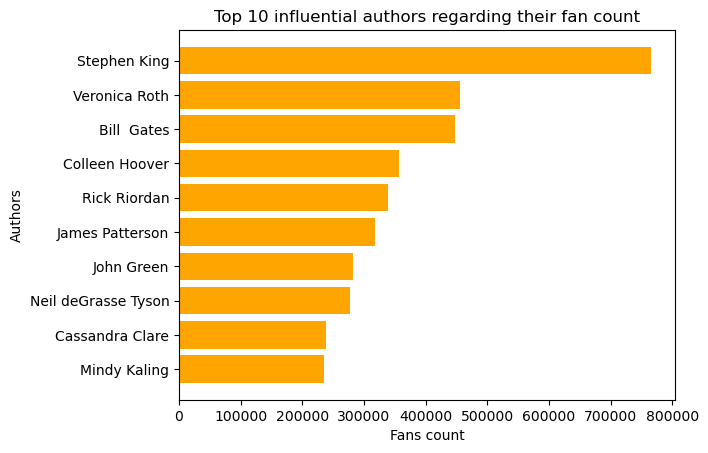

In [4]:
#reversing the lists for plotting necessity     
fans_authors = list(reversed(fans_authors))
fans_count = list(reversed(fans_count))                                     
fans_index = list(reversed(fans_index))

#ploting
plt.barh(fans_authors,fans_count,color='orange')
plt.title('Top 10 influential authors regarding their fan count')            
plt.xlabel('Fans count')
plt.ylabel('Authors')
plt.show()

The most influential author regarding the fans count is Stephen King. \
Let's take a look at the new dataframe:

In [5]:
df_auth

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,15195579,4.04,608956,"[849585, 150259, 1742269, 3230869, 1552134, 46...","[11588, 830502, 149267, 10614, 10592, 43615, 1...",1762,3389,Stephen King,male,https://images.gr-assets.com/authors/136281414...,Stephen Edwin King was born the second son of ...,766035
1,5739316,4.05,277033,"[13155899, 15524542, 15524549, 25457412, 19216...","[13335037, 11735983, 18710190, 18126198, 13615...",57,4039811,Veronica Roth,female,https://images.gr-assets.com/authors/158870727...,Veronica Roth is the #1 New York Times best-se...,455358
2,9418,3.85,562,"[321174, 51432387, 314, 1479853, 60054895, 688...","[36603020, 39731947, 41619, 1081637, 41814307,...",12,23470,Bill Gates,,https://images.gr-assets.com/authors/160374454...,Reading books is one of my favorite ways to le...,446876
3,2239503,4.24,240302,"[21389085, 43940889, 18602144, 24878172, 24878...","[15717943, 27362503, 30333938, 17788401, 24445...",57,5430144,Colleen Hoover,female,https://images.gr-assets.com/authors/146403224...,International and #1 New York Times bestsellin...,356633
4,9144089,4.32,354145,"[3346751, 2377629, 43554, 4551489, 2936530, 10...","[28187, 2120932, 28186, 4556058, 561456, 77361...",172,15872,Rick Riordan,male,https://images.gr-assets.com/authors/160890657...,Rick Riordan is the #1 <i>New York Times</i> b...,339346
5,6514711,3.98,333220,"[3373984, 881425, 1711194, 1829521, 141228, 88...","[13145, 13148, 13137, 13152, 7494, 13139, 1313...",747,3780,James Patterson,male,https://images.gr-assets.com/authors/146834720...,"<a href=""http://www.jamespatterson.com"" rel=""n...",317040
6,7186569,4.03,358221,"[16827462, 919292, 3364505, 48658, 21576687, 6...","[11870085, 99561, 6442769, 49750, 35504431, 65...",57,1406384,John Green,,https://images.gr-assets.com/authors/135345230...,<i>Librarian Note: There is more than one auth...,282537
7,175216,4.07,16300,"[52832605, 1204936, 23561, 16946049, 1323039, ...","[32191710, 20663770, 20663771, 20707975, 20663...",52,12855,Neil deGrasse Tyson,,https://images.gr-assets.com/authors/153503709...,Neil deGrasse Tyson was born and raised in New...,277850
8,7401435,4.24,416177,"[2267189, 3443248, 1575860, 6674837, 6948844, ...","[256683, 3777732, 1582996, 7171637, 6752378, 1...",203,150038,Cassandra Clare,female,https://images.gr-assets.com/authors/127050203...,Hello Goodreadsers. Here's my official bio:<br...,238560
9,611045,3.88,34482,"[15237902, 41897766, 25273867, 60430209, 56458...","[10335308, 30268522, 52435702, 38887475, 35134...",16,194416,Mindy Kaling,,https://images.gr-assets.com/authors/144071858...,"Mindy Kaling is an actor, writer, producer, an...",234647


With the same method used before, we order the top ten authors regarding their number of books (among previous top ten):

In [6]:
works_count = []
works_auth = []

df_authors = df_auth

for i in range(num_aut):
    
    max_works = df_authors['works_count'].max()
    max_index = pd.to_numeric(df_authors['works_count']).idxmax()
    auth_name = df_authors.loc[max_index,'name']
    
    works_count.append(max_works)
    works_auth.append(auth_name)
    
    df_authors = df_authors.drop(max_index)


print(works_auth)    
print(works_count)

['Stephen King', 'James Patterson', 'Cassandra Clare', 'Rick Riordan', 'Veronica Roth', 'Colleen Hoover', 'John Green', 'Neil deGrasse Tyson', 'Mindy Kaling', 'Bill  Gates']
[1762, 747, 203, 172, 57, 57, 57, 52, 16, 12]


and plot them:

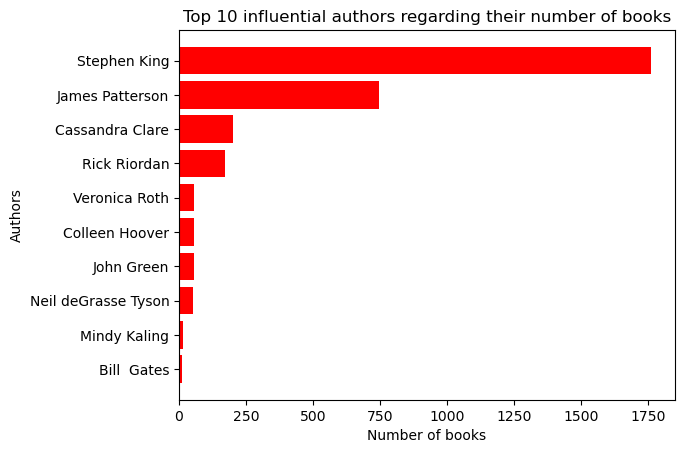

In [7]:
works_auth = list(reversed(works_auth))
works_count = list(reversed(works_count))                                      

plt.barh(works_auth,works_count,color='red')
plt.title('Top 10 influential authors regarding their number of books')            
plt.xlabel('Number of books')
plt.ylabel('Authors')
plt.show()

Even regarding the number of books the most influential author is Stephen King.

### RQ5.2

We now load the data from the "lighter_books.json" file and put the rows of the book regarding to the top ten authors in a pandas dataframe:

In [8]:
data_file = "lighter_books.json"

#definition of the chunk size for working better with this large file
chunk_size = 10000

#reading the file
data = pd.read_json(data_file, lines=True, chunksize=chunk_size, nrows=None)

#defining a list with the top ten authors
list_of_authors = ['Stephen King','Veronica Roth','Bill Gates','Colleen Hoover','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson','Cassandra Clare','Mindy Kaling']

#inizialization of an empty dataframe
df_books = pd.DataFrame()

#chunk loop
for chunk in data:
    df_b = pd.DataFrame(chunk)
    
    #rows loop
    for e in df_b.index:
        
        #if the author is in the top ten, then concat to the new dataframe
        if df_b.loc[e,'author_name'] in list_of_authors:
            row = df_b.loc[e,] 
            df_books = pd.concat([df_books,row.to_frame().T], ignore_index = True)
            

This is how the df_books looks like:

In [9]:
df_books

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,4978,"Wolves of the Calla (The Dark Tower, #5)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,2754911,141651693X,9781416516934,,eng,...,Mass Market Paperback,Pocket Books Premium Edition,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,931,40750,The Dark Tower,5,"[{'name': 'to-read', 'count': 50287}, {'name':...",Roland and his tet have just returned to the p...
1,5091,"The Dark Tower (The Dark Tower, #7)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,6309701,,,,eng,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,1050,40750,The Dark Tower,7,"[{'name': 'to-read', 'count': 56246}, {'name':...",The seventh and final installment of Stephen K...
2,5092,Dark Tower Boxed Set,None,Stephen King,3389,6309704,0451211243,9780451211248,,,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Signet,,40750,The Dark Tower,1-4,"[{'name': 'to-read', 'count': 2786}, {'name': ...",Set in a world of ominous landscape and macabr...
3,5093,"Song of Susannah (The Dark Tower, #6)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,1178083,1416521496,,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,544,40750,The Dark Tower,6,"[{'name': 'to-read', 'count': 45971}, {'name':...","The Wolves have been defeated, but our tet fac..."
4,5094,"The Drawing of the Three (The Dark Tower, #2)",None,Stephen King,3389,2113248,0451210859,9780451210852,,eng,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Signet,463,40750,The Dark Tower,2,"[{'name': 'to-read', 'count': 54858}, {'name':...",While pursuing his quest for the Dark Tower th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16378,25515472,"Lovci pokladů (Treasure Hunters, #1)","[{'id': '3780', 'name': 'James Patterson', 'ro...",James Patterson,3780,23881591,,9788000038612,,cze,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Albatros,468,112891,Treasure Hunters,1,"[{'name': 'to-read', 'count': 10003}, {'name':...","Domácí vyučování může být znamenitá škola, zvl..."
16379,25515684,Shining,None,Stephen King,3389,849585,,,,ger,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Bastei,494,117014,The Shining,1,"[{'name': 'to-read', 'count': 577434}, {'name'...",Alternate cover version for ISBN: 3404130081<b...
16380,25516114,"Athenas tecken (Olympens hjältar, #3)",None,Rick Riordan,15872,17115055,,9789163885785,,swe,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Bonnier Carlsen,557,51379,The Heroes of Olympus,3,"[{'name': 'to-read', 'count': 117817}, {'name'...",Sju halvgudar. Ett flygande skepp. Ett uppdrag...
16381,25518086,The Lost Herondale (Tales from the Shadowhunte...,"[{'id': '150038', 'name': 'Cassandra Clare', '...",Cassandra Clare,150038,42940014,,9781442383975,,eng,...,Audio CD,Unabridged,https://i.gr-assets.com/images/S/compressed.ph...,Simon & Schuster Audio,2,129925,Tales from the Shadowhunter Academy,2,"[{'name': 'to-read', 'count': 10890}, {'name':...",2 discs 1 hour 45 minutes<br /><br />Simon lea...


Now we can check all the series written by the top ten authors:

In [10]:
#definition of a pattern
pattern = r'[(\W),a-zA-Z]'

#inizialization of some usefull lists
list_name_series = []
list_pos_series = []
list_author_series = []

#rows loop
for i in df_books.index:
    
    #saving info for understand if the book is or is not a series book 
    series_pos = df_books.loc[i,'series_position']
    series_id = df_books.loc[i,'series_id']               
    series_name = df_books.loc[i,'series_name']
    series_author = df_books.loc[i,'author_name']

    #if statement
    if series_id != '' and not re.search(pattern,series_pos):
        if series_pos != '1':
            list_name_series.append(series_name)
            list_pos_series.append(series_pos)
            list_author_series.append(series_author)

#defining a set to exclude duplicate series names
set_name_series = set(list_name_series)

print('Yes, the top 10 most influential authors have published many series of book, in total: ',len(set_name_series))

Yes, the top 10 most influential authors have published many series of book, in total:  82


Hence let's make a dataframe usefull for extract the longest series:

In [11]:
#making a dataframe with the name, author and position of the series
df_series = pd.DataFrame(list(zip(list_name_series,list_pos_series,list_author_series)), columns = ['series_name','series_position','author'])
#removing the duplicate rows
df_series = df_series.drop_duplicates(keep = 'first',ignore_index=True)
df_series

,series_name,series_position,author
0,The Dark Tower,5,Stephen King
1,The Dark Tower,7,Stephen King
2,The Dark Tower,6,Stephen King
3,The Dark Tower,2,Stephen King
4,The Dark Tower,3,Stephen King
...,...,...,...
244,Alex Cross,23,James Patterson
245,House of Robots,2,James Patterson
246,I Funny,4,James Patterson
247,Private,10,James Patterson


In [12]:
#calculating the max position, the respective index, author and name
max_pos = pd.to_numeric(df_series['series_position']).max(axis = 0)
max_index = pd.to_numeric(df_series['series_position']).idxmax()
max_name = df_series.loc[max_index,'series_name']
max_author = df_series.loc[max_index,'author']

print('The longest series name is:', max_name, 'from', max_author, 'which is composed by', int(max_pos))

The longest series name is: Batman (1940-2011) from Stephen King which is composed by 400


We have to remove this result because to this series stephen king has worked on a few occasions but is not an his own series. \
So let's remove this row and recalculate:

In [13]:
df_series = df_series.drop(max_index)

In [14]:
max_pos = pd.to_numeric(df_series['series_position']).max(axis = 0)
max_index = pd.to_numeric(df_series['series_position']).idxmax()
max_name = df_series.loc[max_index,'series_name']
max_author = df_series.loc[max_index,'author']

print('The longest series name is:', max_name, 'from', max_author, 'which is composed by', int(max_pos), 'books')

The longest series name is: Alex Cross from James Patterson which is composed by 23 books


### RQ5.3

Let's checking if the top ten authors have published in differt formats using the df_books dataframe created before

In [15]:
list_of_authors = ['Stephen King','Veronica Roth','Bill Gates','Colleen Hoover','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson','Cassandra Clare','Mindy Kaling']
number = 0 

#authors loop
for i in list_of_authors:
    
    #inizializating a list that will cointain the formats
    form = []
    
    #rows loop
    for e in df_books.index:
        
        #appending the format
        if df_books.loc[e,'author_name'] == i:
            form.append(df_books.loc[e,'format'])
    
    #p is a variable used to checking if the formats are different
    p = 0
    
    #loop along form list
    for t in range(1,len(form)):
        
        #if the formats are different print the author
        if form[t] == form[t-1] and p == 0:
            print(i+' has been published in different format.')
            p = 1
            number += 1
            
print(number,'authors have been published in different format')

Stephen King has been published in different format.
Veronica Roth has been published in different format.
Colleen Hoover has been published in different format.
Rick Riordan has been published in different format.
James Patterson has been published in different format.
John Green has been published in different format.
Neil deGrasse Tyson has been published in different format.
Cassandra Clare has been published in different format.
Mindy Kaling has been published in different format.
9 authors have been published in different format


It seems that there are not Bill Gates's books in this dataset (lighter_books.json). \
Now we can looking for all the formats used by the authors and plot the most relevant:

In [16]:
#list of the top ten authors
list_of_authors = ['Stephen King','Veronica Roth','Bill Gates','Colleen Hoover','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson','Cassandra Clare','Mindy Kaling']

#empty list
formats = []

#rows loop
for e in df_books.index:
    
    #appending the format to the list
    if df_books.loc[e,'author_name'] in list_of_authors and df_books.loc[e,'format'] != '':
        formats.append(df_books.loc[e,'format'])

#creating a pandas series
formats = pd.Series(formats)

#calculating the counts for each format
formats.value_counts()



Paperback                   5536
Hardcover                   2926
ebook                       1579
Audio CD                     878
Audiobook                    666
                            ... 
Boxed Set                      1
Pamphlet                       1
Loose Leaf                     1
Preloaded Digital Player       1
Electronic Book                1
Name: count, Length: 76, dtype: int64

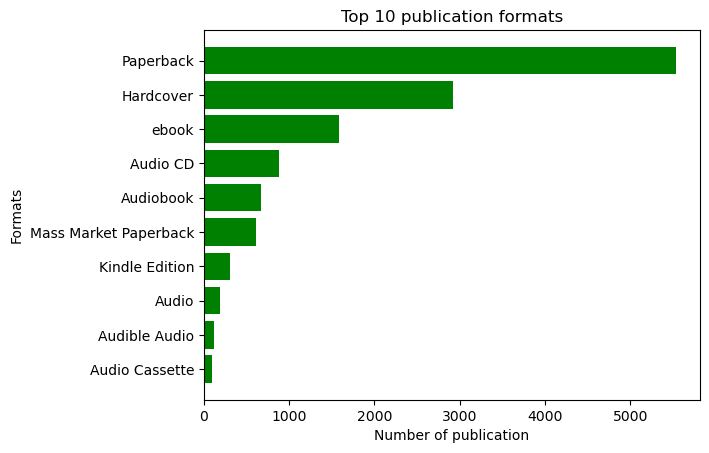

In [17]:
#barplot of the top ten most relevant formats

plt.barh(list(reversed(formats.value_counts().index[:10])),list(reversed(formats.value_counts()[:10])),color='green')
plt.title('Top 10 publication formats')            
plt.xlabel('Number of publication')
plt.ylabel('Formats')
plt.show()

Of course the main format is represented from the paper, but also the digital formats like ebook or audiobook are being relevent.

### RQ5.4

Now we can have a look of the general response from the readers dividing the authors by gender:

In [18]:
#division by gender
male_authors = ['Stephen King','Bill Gates','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson']
female_authors = ['Veronica Roth','Colleen Hoover','Cassandra Clare','Mindy Kaling']

#inizialization of dataframes
df_male_authors = pd.DataFrame()
df_female_authors = pd.DataFrame()

#looping on df_auth rows, this is the dataframe crated in RQ1
for i in df_auth.index:
    
    #adding the row to the respective dataframe
    if df_auth.loc[i,'name'] in male_authors:
        row = df_auth.loc[i,]
        df_male_authors = pd.concat([df_male_authors,row.to_frame().T], ignore_index = True)
    elif df_auth.loc[i,'name'] in female_authors:
        row = df_auth.loc[i,]
        df_female_authors = pd.concat([df_female_authors,row.to_frame().T], ignore_index = True)

These are the dataframe divided by gender:

In [19]:
df_male_authors

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,15195579,4.04,608956,"[849585, 150259, 1742269, 3230869, 1552134, 46...","[11588, 830502, 149267, 10614, 10592, 43615, 1...",1762,3389,Stephen King,male,https://images.gr-assets.com/authors/136281414...,Stephen Edwin King was born the second son of ...,766035
1,9144089,4.32,354145,"[3346751, 2377629, 43554, 4551489, 2936530, 10...","[28187, 2120932, 28186, 4556058, 561456, 77361...",172,15872,Rick Riordan,male,https://images.gr-assets.com/authors/160890657...,Rick Riordan is the #1 <i>New York Times</i> b...,339346
2,6514711,3.98,333220,"[3373984, 881425, 1711194, 1829521, 141228, 88...","[13145, 13148, 13137, 13152, 7494, 13139, 1313...",747,3780,James Patterson,male,https://images.gr-assets.com/authors/146834720...,"<a href=""http://www.jamespatterson.com"" rel=""n...",317040
3,7186569,4.03,358221,"[16827462, 919292, 3364505, 48658, 21576687, 6...","[11870085, 99561, 6442769, 49750, 35504431, 65...",57,1406384,John Green,,https://images.gr-assets.com/authors/135345230...,<i>Librarian Note: There is more than one auth...,282537
4,175216,4.07,16300,"[52832605, 1204936, 23561, 16946049, 1323039, ...","[32191710, 20663770, 20663771, 20707975, 20663...",52,12855,Neil deGrasse Tyson,,https://images.gr-assets.com/authors/153503709...,Neil deGrasse Tyson was born and raised in New...,277850


In [20]:
df_female_authors

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,5739316,4.05,277033,"[13155899, 15524542, 15524549, 25457412, 19216...","[13335037, 11735983, 18710190, 18126198, 13615...",57,4039811,Veronica Roth,female,https://images.gr-assets.com/authors/158870727...,Veronica Roth is the #1 New York Times best-se...,455358
1,2239503,4.24,240302,"[21389085, 43940889, 18602144, 24878172, 24878...","[15717943, 27362503, 30333938, 17788401, 24445...",57,5430144,Colleen Hoover,female,https://images.gr-assets.com/authors/146403224...,International and #1 New York Times bestsellin...,356633
2,7401435,4.24,416177,"[2267189, 3443248, 1575860, 6674837, 6948844, ...","[256683, 3777732, 1582996, 7171637, 6752378, 1...",203,150038,Cassandra Clare,female,https://images.gr-assets.com/authors/127050203...,Hello Goodreadsers. Here's my official bio:<br...,238560
3,611045,3.88,34482,"[15237902, 41897766, 25273867, 60430209, 56458...","[10335308, 30268522, 52435702, 38887475, 35134...",16,194416,Mindy Kaling,,https://images.gr-assets.com/authors/144071858...,"Mindy Kaling is an actor, writer, producer, an...",234647


Finally we plot using different response and dividing the authors by gender:

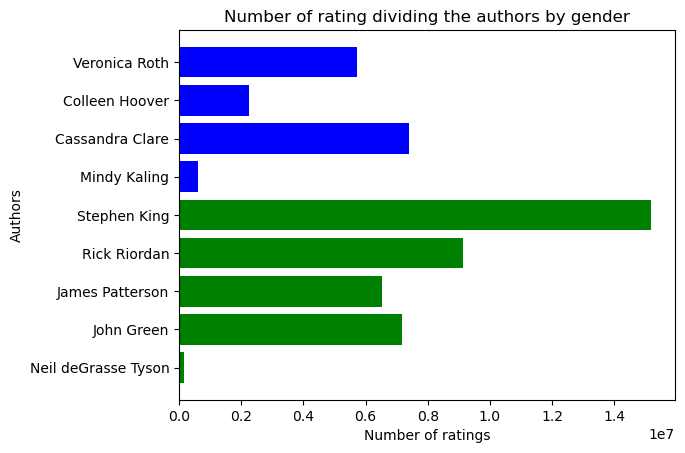

In [21]:
plt.barh(list(reversed(df_male_authors.loc[:,'name'])),list(reversed(df_male_authors.loc[:,'ratings_count'])),color='green')
plt.title('Number of rating dividing the authors by gender')            
plt.xlabel('Number of ratings')
plt.ylabel('Authors')
plt.barh(list(reversed(df_female_authors.loc[:,'name'])),list(reversed(df_female_authors.loc[:,'ratings_count'])),color='blue')
plt.show()

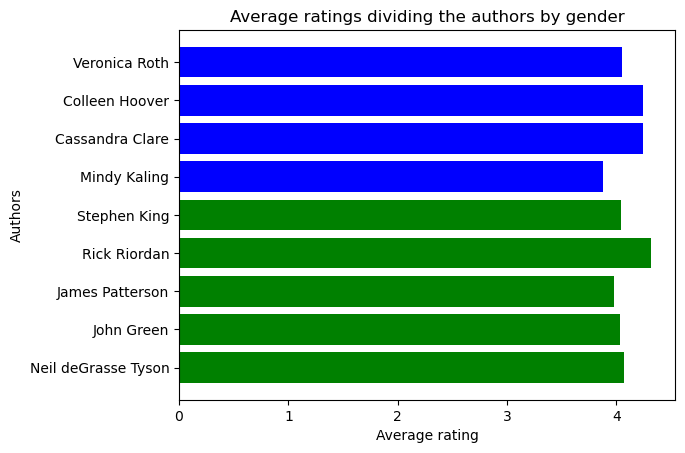

In [22]:
plt.barh(list(reversed(df_male_authors.loc[:,'name'])),list(reversed(df_male_authors.loc[:,'average_rating'])),color='green')
plt.title('Average ratings dividing the authors by gender')            
plt.xlabel('Average rating')
plt.ylabel('Authors')
plt.barh(list(reversed(df_female_authors.loc[:,'name'])),list(reversed(df_female_authors.loc[:,'average_rating'])),color='blue')
plt.show()

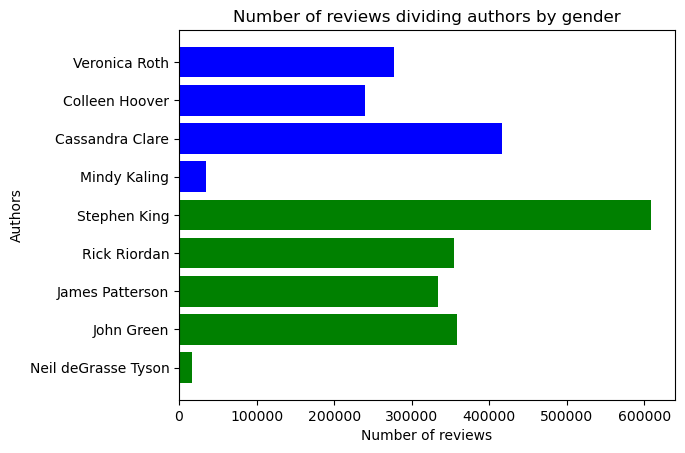

In [23]:
plt.barh(list(reversed(df_male_authors.loc[:,'name'])),list(reversed(df_male_authors.loc[:,'text_reviews_count'])),color='green')
plt.title('Number of reviews dividing authors by gender')            
plt.xlabel('Number of reviews')
plt.ylabel('Authors')
plt.barh(list(reversed(df_female_authors.loc[:,'name'])),list(reversed(df_female_authors.loc[:,'text_reviews_count'])),color='blue')
plt.show()

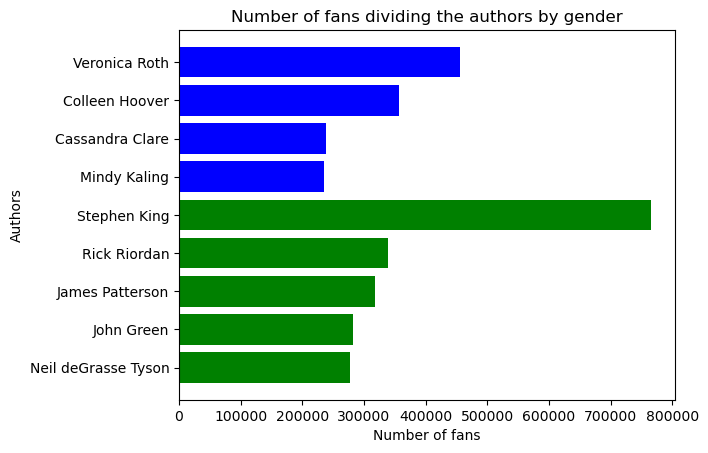

In [24]:
plt.barh(list(reversed(df_male_authors.loc[:,'name'])),list(reversed(df_male_authors.loc[:,'fans_count'])),color='green')
plt.title('Number of fans dividing the authors by gender')            
plt.xlabel('Number of fans')
plt.ylabel('Authors')
plt.barh(list(reversed(df_female_authors.loc[:,'name'])),list(reversed(df_female_authors.loc[:,'fans_count'])),color='blue')
plt.show()

From the plots it seems, excluding the most important author Stephen King, that there is a little gender gap at the expense of the famale authors which probably we can consider as a stuctural bias.  

## RQ6

### RQ6.1

These are the authors and the dataframe usefull for this part (top ten author made before and dataframe created in RQ5):

In [25]:
list_of_authors = ['Stephen King','Veronica Roth','Bill Gates','Colleen Hoover','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson','Cassandra Clare','Mindy Kaling']

#df_books contains the row of lighter_books.json file concerning the top ten authors only
df_books

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,4978,"Wolves of the Calla (The Dark Tower, #5)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,2754911,141651693X,9781416516934,,eng,...,Mass Market Paperback,Pocket Books Premium Edition,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,931,40750,The Dark Tower,5,"[{'name': 'to-read', 'count': 50287}, {'name':...",Roland and his tet have just returned to the p...
1,5091,"The Dark Tower (The Dark Tower, #7)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,6309701,,,,eng,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,1050,40750,The Dark Tower,7,"[{'name': 'to-read', 'count': 56246}, {'name':...",The seventh and final installment of Stephen K...
2,5092,Dark Tower Boxed Set,None,Stephen King,3389,6309704,0451211243,9780451211248,,,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Signet,,40750,The Dark Tower,1-4,"[{'name': 'to-read', 'count': 2786}, {'name': ...",Set in a world of ominous landscape and macabr...
3,5093,"Song of Susannah (The Dark Tower, #6)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,1178083,1416521496,,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,544,40750,The Dark Tower,6,"[{'name': 'to-read', 'count': 45971}, {'name':...","The Wolves have been defeated, but our tet fac..."
4,5094,"The Drawing of the Three (The Dark Tower, #2)",None,Stephen King,3389,2113248,0451210859,9780451210852,,eng,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Signet,463,40750,The Dark Tower,2,"[{'name': 'to-read', 'count': 54858}, {'name':...",While pursuing his quest for the Dark Tower th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16378,25515472,"Lovci pokladů (Treasure Hunters, #1)","[{'id': '3780', 'name': 'James Patterson', 'ro...",James Patterson,3780,23881591,,9788000038612,,cze,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Albatros,468,112891,Treasure Hunters,1,"[{'name': 'to-read', 'count': 10003}, {'name':...","Domácí vyučování může být znamenitá škola, zvl..."
16379,25515684,Shining,None,Stephen King,3389,849585,,,,ger,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Bastei,494,117014,The Shining,1,"[{'name': 'to-read', 'count': 577434}, {'name'...",Alternate cover version for ISBN: 3404130081<b...
16380,25516114,"Athenas tecken (Olympens hjältar, #3)",None,Rick Riordan,15872,17115055,,9789163885785,,swe,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Bonnier Carlsen,557,51379,The Heroes of Olympus,3,"[{'name': 'to-read', 'count': 117817}, {'name'...",Sju halvgudar. Ett flygande skepp. Ett uppdrag...
16381,25518086,The Lost Herondale (Tales from the Shadowhunte...,"[{'id': '150038', 'name': 'Cassandra Clare', '...",Cassandra Clare,150038,42940014,,9781442383975,,eng,...,Audio CD,Unabridged,https://i.gr-assets.com/images/S/compressed.ph...,Simon & Schuster Audio,2,129925,Tales from the Shadowhunter Academy,2,"[{'name': 'to-read', 'count': 10890}, {'name':...",2 discs 1 hour 45 minutes<br /><br />Simon lea...


Now we find the average time gap of two subsequential publication for a series for each author and generally for the top ten authors:

In [26]:
#pattern
pattern = r'[(\W),a-zA-Z]'

#lists inizialization
list_name_series = []
list_pos_series = []
list_author_series = []
list_date_series = []
list_id_series = []

#row loop
for i in df_books.index:
    
    #saving info
    series_pos = df_books.loc[i,'series_position']
    series_id = df_books.loc[i,'series_id']              
    series_name = df_books.loc[i,'series_name']
    series_author = df_books.loc[i,'author_name']
    series_origin_pub = df_books.loc[i,'original_publication_date']

    #appending only if the book is part of a series
    if series_id != '' and not re.search(pattern,series_pos):
        if series_pos != '' and series_origin_pub != '':
            list_name_series.append(series_name)
            list_pos_series.append(series_pos)
            list_author_series.append(series_author)
            list_id_series.append(series_id)
            list_date_series.append(series_origin_pub)
            


In [27]:
#creating a new dataframe with the info found:
df_pub_date = pd.DataFrame(list(zip(list_id_series,list_name_series,list_pos_series,list_author_series,list_date_series)), columns = ['series_id','series_name','series_position','author','origin_date_pub'])
df_pub_date = df_pub_date.drop_duplicates(keep = 'first',ignore_index=True)
df_pub_date

,series_id,series_name,series_position,author,origin_date_pub
0,40750,The Dark Tower,5,Stephen King,2003-11-04
1,40750,The Dark Tower,7,Stephen King,2004-09-21
2,40750,The Dark Tower,6,Stephen King,2004-06-08
3,40750,The Dark Tower,2,Stephen King,1987-05
4,40750,The Dark Tower,3,Stephen King,1991-08
...,...,...,...,...,...
294,40543,Alex Cross,23,James Patterson,2015-11-23
295,162672,House of Robots,2,James Patterson,2015-11-23
296,113257,I Funny,4,James Patterson,2015-12-14
297,132156,Private,10,James Patterson,2016-03-14


In [28]:
#changing the original publication dates to datetime objects 
df_pub_date['origin_date_pub'] = pd.to_datetime(df_pub_date['origin_date_pub'],format ='mixed')
df_pub_date

,series_id,series_name,series_position,author,origin_date_pub
0,40750,The Dark Tower,5,Stephen King,2003-11-04
1,40750,The Dark Tower,7,Stephen King,2004-09-21
2,40750,The Dark Tower,6,Stephen King,2004-06-08
3,40750,The Dark Tower,2,Stephen King,1987-05-01
4,40750,The Dark Tower,3,Stephen King,1991-08-01
...,...,...,...,...,...
294,40543,Alex Cross,23,James Patterson,2015-11-23
295,162672,House of Robots,2,James Patterson,2015-11-23
296,113257,I Funny,4,James Patterson,2015-12-14
297,132156,Private,10,James Patterson,2016-03-14


In [29]:
#sorting by the date
df_pub_date = df_pub_date.sort_values(by='origin_date_pub')
df_pub_date

,series_id,series_name,series_position,author,origin_date_pub
14,117014,The Shining,1,Stephen King,1977-01-28
81,141740,Danse macabre,1,Stephen King,1978-01-01
71,141740,Danse macabre,4,Stephen King,1978-01-01
72,141740,Danse macabre,3,Stephen King,1978-01-01
80,141740,Danse macabre,2,Stephen King,1978-01-01
...,...,...,...,...,...
221,104049,The Last Hours,2,Cassandra Clare,2021-03-02
224,104133,The Wicked Powers,1,Cassandra Clare,2022-01-01
222,104049,The Last Hours,3,Cassandra Clare,2022-03-01
225,104133,The Wicked Powers,2,Cassandra Clare,2023-01-01


In [30]:
list_of_authors = ['Stephen King','Veronica Roth','Bill Gates','Colleen Hoover','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson','Cassandra Clare','Mindy Kaling']
tot_mean = []

#authors loop
for d in list_of_authors:
    l_s = [] 
    mean = []
    
    #rows loop
    for e in df_pub_date.index:
        if df_pub_date.loc[e,'author'] == d:
            l_s.append(df_pub_date.loc[e,'series_name'])
    
    #used set for remove the duplicates    
    l_s = set(l_s)


    #looping on the series name by the author
    for i in l_s:
        date = []
        
        #appending the dates for a series
        for t in df_pub_date.index:
            if df_pub_date.loc[t,'series_name'] == i:
                date.append(df_pub_date.loc[t,'origin_date_pub'])
        
        l_p = []
        
        #looping for calculating the time difference
        for p in range(1,len(date)):
        
            delta_t = date[p]-date[p-1]                                  
            l_p.append(delta_t)
        
        #creating a series
        l_p_s = pd.Series(l_p)
        
        #mean of the series which contains the time delta for each subsequent publication
        m = l_p_s.mean(numeric_only = False)
        
        #appending to calculate the mean along all the series by an author 
        mean.append(m)
    
    #mean of an author
    mean = pd.Series(mean)
    mean = abs(mean.mean())
    
    #appending to tot_mean 
    tot_mean.append(mean)
    
    #if statement necessary because the value for Bill Gates was NaN
    if type(mean) != float:
        print('The average gap by', d, 'is:', mean.days, 'days')

#mean along all the authors
tot_mean = pd.Series(tot_mean)        
print('The average gap along all the authors is:', tot_mean.mean().days, 'days')
    

The average gap by Stephen King is: 1282 days
The average gap by Veronica Roth is: 455 days
The average gap by Colleen Hoover is: 210 days
The average gap by Rick Riordan is: 488 days
The average gap by James Patterson is: 882 days
The average gap by John Green is: 579 days
The average gap by Neil deGrasse Tyson is: 3287 days
The average gap by Cassandra Clare is: 369 days
The average gap along all the authors is: 944 days


With the same method we can calculate the average time gap between two publications that don't belong to a series:

In [31]:
#list inizialization
list_author_book = []
list_date_book = []
list_name_book = []

for i in df_books.index:
    
    #saving info
    book_author = df_books.loc[i,'author_name']
    book_origin_pub = df_books.loc[i,'original_publication_date']
    series_id = df_books.loc[i,'series_id']
    book_name = df_books.loc[i,'title']

    #checking if the book is a series or not
    if series_id == '' and book_origin_pub != '':
            
            
            list_author_book.append(book_author)
            list_name_book.append(book_name)
            list_date_book.append(book_origin_pub)
            


In [32]:
#creating the dataframe with the info
df_pub_date = pd.DataFrame(list(zip(list_author_book,list_name_book,list_date_book)), columns = ['author','title','origin_date_pub'])
df_pub_date = df_pub_date.drop_duplicates(keep = 'first',ignore_index=True)
df_pub_date

,author,title,origin_date_pub
0,Stephen King,Los ojos del dragón,1987-02-02
1,Stephen King,The Stand,1978-10-03
2,Stephen King,Apocalipsis,1978-10-03
3,Stephen King,The Stand: Das letzte Gefecht,1978-10-03
4,Stephen King,'Salem's Lot,1975-10-17
...,...,...,...
2285,Neil deGrasse Tyson,Wielki początek. 14 miliardów lat kosmicznej e...,2004-09-28
2286,Stephen King,The Dreamcatcher Stephen King,2001-03-20
2287,James Patterson,Kenny Wright: Superhero (Kenny Wright 1),2015-03-01
2288,Stephen King,Αναβίωση,2014-11-11


In [33]:
#converting date to datetime object
df_pub_date['origin_date_pub'] = pd.to_datetime(df_pub_date['origin_date_pub'],format ='mixed',errors='coerce')
df_pub_date

,author,title,origin_date_pub
0,Stephen King,Los ojos del dragón,1987-02-02
1,Stephen King,The Stand,1978-10-03
2,Stephen King,Apocalipsis,1978-10-03
3,Stephen King,The Stand: Das letzte Gefecht,1978-10-03
4,Stephen King,'Salem's Lot,1975-10-17
...,...,...,...
2285,Neil deGrasse Tyson,Wielki początek. 14 miliardów lat kosmicznej e...,2004-09-28
2286,Stephen King,The Dreamcatcher Stephen King,2001-03-20
2287,James Patterson,Kenny Wright: Superhero (Kenny Wright 1),2015-03-01
2288,Stephen King,Αναβίωση,2014-11-11


In [34]:
#sorting
df_pub_date = df_pub_date.sort_values(by='origin_date_pub',ignore_index = True)
df_pub_date

,author,title,origin_date_pub
0,Stephen King,"People, Places, and Things",1960-01-01
1,Stephen King,The Outlaw,1960-11-01
2,Stephen King,In a Half World of Terror,1966-01-01
3,Stephen King,Slade,1970-06-01
4,Stephen King,The Mangler,1972-12-01
...,...,...,...
2285,Stephen King,"The Man Who Wouldn't Shake Hands, & Word Proce...",NaT
2286,Stephen King,Pet Sematary/Carrie/Night Shift,NaT
2287,James Patterson,Women's Murder Club #5-8 omnibus,NaT
2288,Stephen King,Stephen King 4,NaT


In [35]:
#removing rows with NaT value in the date column
for i in df_pub_date.index:
    if pd.isnull(df_pub_date.loc[i,'origin_date_pub']):
        df_pub_date = df_pub_date.drop(i)
        

In [36]:
#the cleaned dataframe
df_pub_date

,author,title,origin_date_pub
0,Stephen King,"People, Places, and Things",1960-01-01
1,Stephen King,The Outlaw,1960-11-01
2,Stephen King,In a Half World of Terror,1966-01-01
3,Stephen King,Slade,1970-06-01
4,Stephen King,The Mangler,1972-12-01
...,...,...,...
2279,James Patterson,Treasure Hunters 3-Book Boxed Set,2015-10-13
2280,Stephen King,The Bazaar of Bad Dreams,2015-11-03
2281,Colleen Hoover,November 9,2015-11-10
2282,John Green,Turtles All the Way Down,2017-10-10


In [37]:
list_of_authors = ['Stephen King','Veronica Roth','Bill Gates','Colleen Hoover','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson','Cassandra Clare','Mindy Kaling']
tot_mean = []

#authors loop
for d in list_of_authors:
    date = [] 
    mean = []
    
    #rows loop
    for e in df_pub_date.index:
        if df_pub_date.loc[e,'author'] == d:
            date.append(df_pub_date.loc[e,'origin_date_pub'])
    l_p = []
    
    for p in range(1,len(date)):
        delta_t = date[p]-date[p-1]                                  
        l_p.append(delta_t)
    
    l_p_s = pd.Series(l_p)
    mean = abs(l_p_s.mean(numeric_only = False))
    
    tot_mean.append(mean)
    
    if type(mean) != float:
        print('The average gap by', d, 'is:', mean.days, 'days')

tot_mean = pd.Series(tot_mean)        
print('The average gap along all the authors:', tot_mean.mean().days, 'days')   



The average gap by Stephen King is: 13 days
The average gap by Veronica Roth is: 178 days
The average gap by Colleen Hoover is: 116 days
The average gap by Rick Riordan is: 695 days
The average gap by James Patterson is: 35 days
The average gap by John Green is: 25 days
The average gap by Neil deGrasse Tyson is: 262 days
The average gap by Cassandra Clare is: 230 days
The average gap by Mindy Kaling is: 999 days
The average gap along all the authors: 284 days


From the results we obtained seems that, meanly, the time gap of publication of a generic book is smaller than the subsequent publication of two books from the same series. That looks as we aspected, in facts is reasonable that an author is working at different works while writing a series.

### RQ6.2

Let's use as before the df_books dataframe

In [38]:
df_books

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,4978,"Wolves of the Calla (The Dark Tower, #5)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,2754911,141651693X,9781416516934,,eng,...,Mass Market Paperback,Pocket Books Premium Edition,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,931,40750,The Dark Tower,5,"[{'name': 'to-read', 'count': 50287}, {'name':...",Roland and his tet have just returned to the p...
1,5091,"The Dark Tower (The Dark Tower, #7)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,6309701,,,,eng,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,1050,40750,The Dark Tower,7,"[{'name': 'to-read', 'count': 56246}, {'name':...",The seventh and final installment of Stephen K...
2,5092,Dark Tower Boxed Set,None,Stephen King,3389,6309704,0451211243,9780451211248,,,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Signet,,40750,The Dark Tower,1-4,"[{'name': 'to-read', 'count': 2786}, {'name': ...",Set in a world of ominous landscape and macabr...
3,5093,"Song of Susannah (The Dark Tower, #6)","[{'id': '3389', 'name': 'Stephen King', 'role'...",Stephen King,3389,1178083,1416521496,,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Pocket Books,544,40750,The Dark Tower,6,"[{'name': 'to-read', 'count': 45971}, {'name':...","The Wolves have been defeated, but our tet fac..."
4,5094,"The Drawing of the Three (The Dark Tower, #2)",None,Stephen King,3389,2113248,0451210859,9780451210852,,eng,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Signet,463,40750,The Dark Tower,2,"[{'name': 'to-read', 'count': 54858}, {'name':...",While pursuing his quest for the Dark Tower th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16378,25515472,"Lovci pokladů (Treasure Hunters, #1)","[{'id': '3780', 'name': 'James Patterson', 'ro...",James Patterson,3780,23881591,,9788000038612,,cze,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Albatros,468,112891,Treasure Hunters,1,"[{'name': 'to-read', 'count': 10003}, {'name':...","Domácí vyučování může být znamenitá škola, zvl..."
16379,25515684,Shining,None,Stephen King,3389,849585,,,,ger,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Bastei,494,117014,The Shining,1,"[{'name': 'to-read', 'count': 577434}, {'name'...",Alternate cover version for ISBN: 3404130081<b...
16380,25516114,"Athenas tecken (Olympens hjältar, #3)",None,Rick Riordan,15872,17115055,,9789163885785,,swe,...,Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Bonnier Carlsen,557,51379,The Heroes of Olympus,3,"[{'name': 'to-read', 'count': 117817}, {'name'...",Sju halvgudar. Ett flygande skepp. Ett uppdrag...
16381,25518086,The Lost Herondale (Tales from the Shadowhunte...,"[{'id': '150038', 'name': 'Cassandra Clare', '...",Cassandra Clare,150038,42940014,,9781442383975,,eng,...,Audio CD,Unabridged,https://i.gr-assets.com/images/S/compressed.ph...,Simon & Schuster Audio,2,129925,Tales from the Shadowhunter Academy,2,"[{'name': 'to-read', 'count': 10890}, {'name':...",2 discs 1 hour 45 minutes<br /><br />Simon lea...


We collected the data and plotted a cumulative histogram for each author:  

<function matplotlib.pyplot.show(close=None, block=None)>

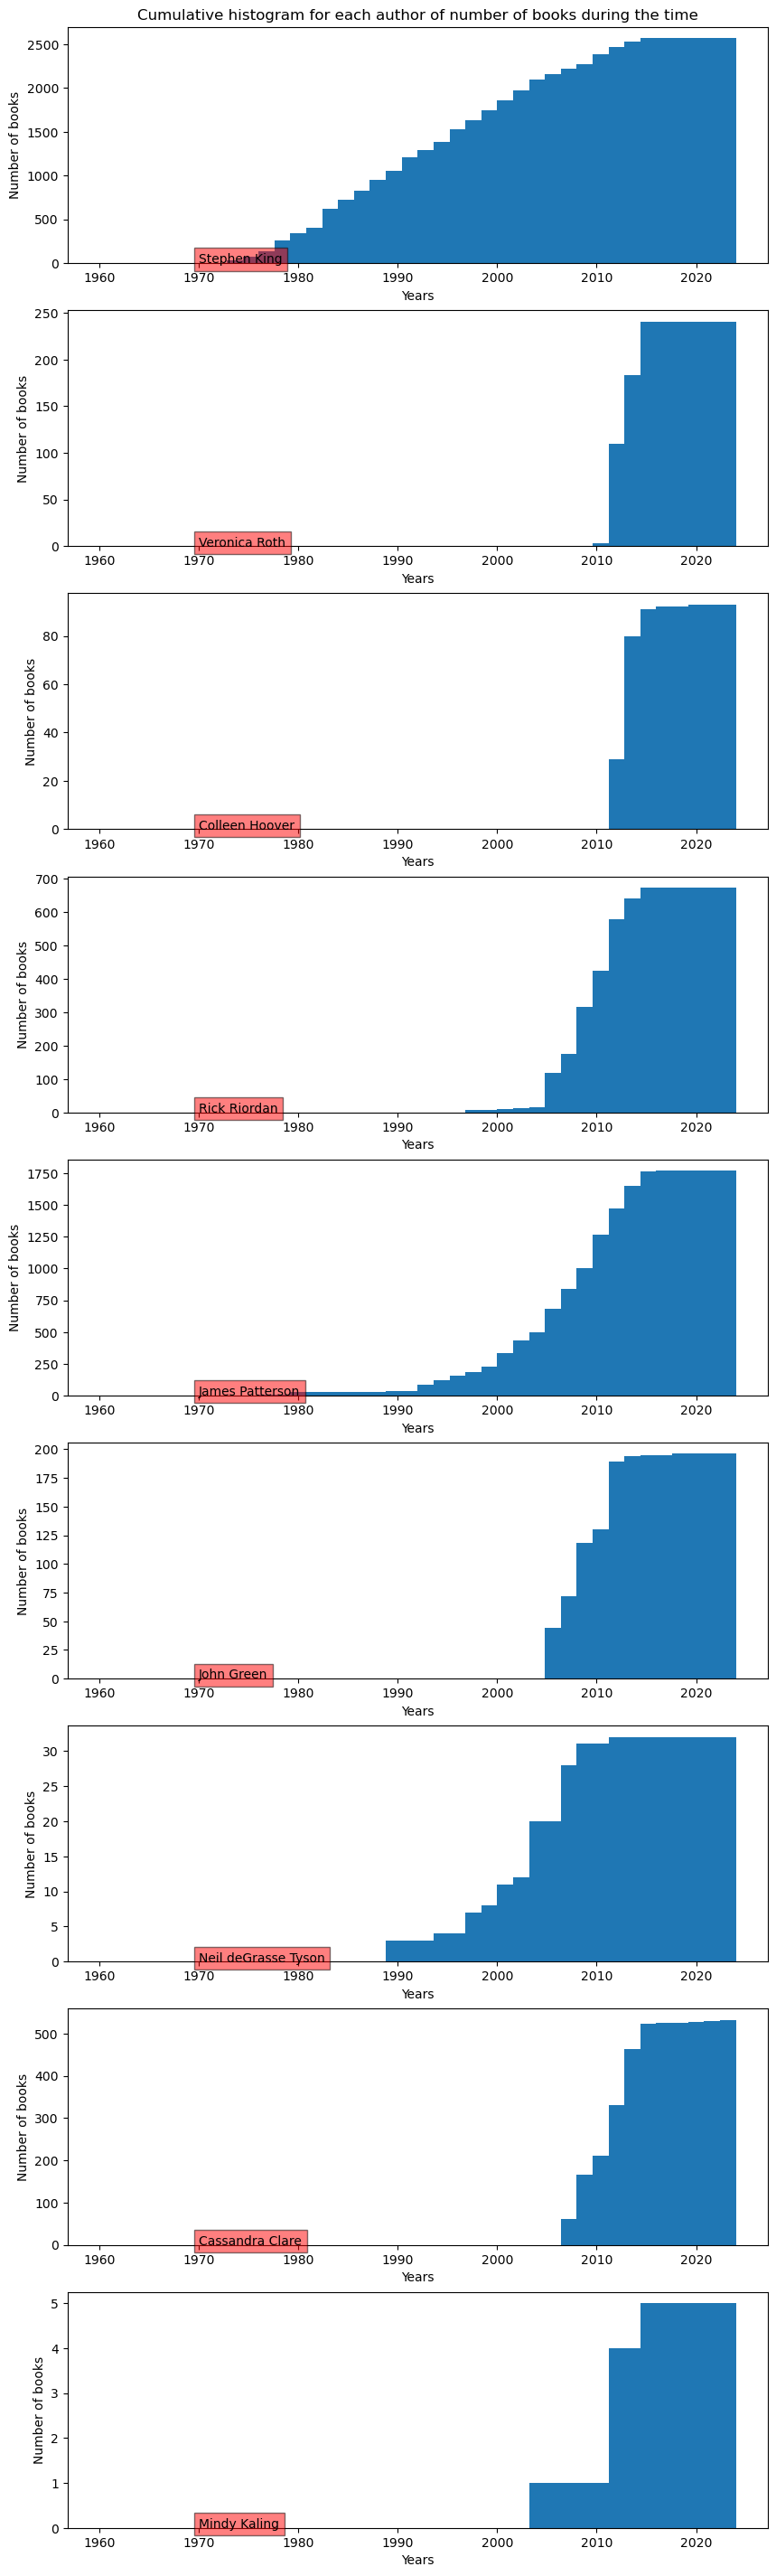

In [39]:
#top 9 author, we removed Bill Gates because it seems that there are not books of this author in the dataset
list_of_authors = ['Stephen King','Veronica Roth','Colleen Hoover','Rick Riordan','James Patterson','John Green','Neil deGrasse Tyson','Cassandra Clare','Mindy Kaling']

#count of the looping lap
count = 0

#inizialization of the figure
plt.figure(figsize = (10,40))

#authors loop
for t in list_of_authors:
    
    #list and dataframe inizialization
    title = []
    pub_date = []
    df_year = pd.DataFrame()
    
    #rows loop
    for i in df_books.index:
        
        #appending info
        if df_books.loc[i,'author_name'] == t:
            title.append(df_books.loc[i,'title'])
            pub_date.append(df_books.loc[i,'original_publication_date'])
    
    #creating a dataframe with the info
    df_year = pd.DataFrame(list(zip(title,pub_date)), columns = ['title','origin_date_pub'])
    
    #removing duplicates
    df_year = df_year.drop_duplicates(keep = 'first',ignore_index=True)
    
    #creating datetime objects
    df_year['origin_date_pub'] = pd.to_datetime(df_year['origin_date_pub'],format ='mixed',errors='coerce')
    
    #sorting
    df_year = df_year.sort_values(by='origin_date_pub',ignore_index = True)
    
    #removing rows with NaT values
    for e in df_year.index:
        if pd.isnull(df_year.loc[e,'origin_date_pub']):
            df_year = df_year.drop(e)
    
    count += 1
    
    #sublot inizialization
    plt.subplot(10,1,count)
    
    #adding the author's name on the subplot
    plt.text(0.,0.,t,bbox=dict(facecolor='red', alpha=0.5))
    
    #making the title of plot, only for the first lap
    if count == 1:
        plt.title('Cumulative histogram for each author of number of books during the time')
    
    #making the cumulative histogram
    plt.hist(df_year['origin_date_pub'], bins = 40, range = (datetime(1960,1,1),datetime(2024,1,1)), cumulative = True)
    
    #labeling
    plt.ylabel('Number of books')
    plt.xlabel('Years')
    
    
    
    
#showing the figure
plt.show


The histograms show the publications during the years for each author in cumulative way. From the plots we can notice that all the authors are mostly constant regarding their publication during the time and, except for Stephen King that is publicating since seventies, the other authors seem almost contemporary.

### [RQ7]
Estimating probabilities is a core skill for a data scientist: show us your best!

1. Estimate the probability that a book has over 30% of the ratings above 4.
2. Estimate the probability that an author publishes a new book within two years from its last work.
3. In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.
4. Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

#### ad 1.
Estimate the probability that a book has over 30% of the ratings above 4.

After inspecting the .json-file "lighter_authors" we decided to use the attribute "rate_dist".
First we took a look at the format of this attribute and examined its general structure is

'rating_dist': '5:1674064|4:664833|3:231195|2:41699|1:16215|total:2628006'

Just with different numbers, we build our functions to process this information as the following code shows:

In [ ]:
books_with_30Percent_of_ratings_above_4, books_with_at_least_one_rating = processing.answer_rq_7_1(data_path)

The process lasted approximately 697.38 seconds.
We have found 3998205 books with 30 Percent of ratings above 4
We have found 6017150 books with at least one rating
The share of books with 30Percent of ratings above 4 is approximately:  0.6645
The process lasted approximately 697.38 seconds.


### ad 2.
Estimate the probability that an author publishes a new book within two years from its last work.

In [ ]:
results = processing.answer_rq_7_2(data_path)

0.5201 is the probability that an author publishes a book within 2 years
The process lasted approximately 766.49 seconds.


### ad 3. & 4.
3. In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.
4. Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

In [ ]:
worst_book_ids_of_all_time_set = processing.get_worst_book_ids_of_all_time(data_path)
contingency_table = processing.get_contingency_table_for_rq_7_3(data_path, worst_book_ids_of_all_time_set)
print("the contingency table looks like:")
contingency_table

The process lasted approximately 61.91 seconds.
The process lasted approximately 710.96 seconds.
the contingency table looks like:


gt700,False,True
oneOftheWorst,,
False,3811564,110900
True,5503,220


In [ ]:
res = processing.answer_rq_7_3(contingency_table)

Now we can provide the answer to 3.
by computing the ratio of the entry for "gt700 and oneOftheWorst", which is  220 ,
divided by the number of books with over 700 pages, which is 5723 .
This yields a probability of approximately: 0.0384


The fisher test is an exact hypothesis test to check independence of two binary features like given in 4.

In [ ]:
# now performing the fisher test for answering independency
pval = processing.perform_fisher_test_and_interprete(contingency_table, alpha = 0.05)

assuming a test-level of alpha = 0.05
Since the pvalue is approximately 0.000011 , i.e. less than or equal to alpha, 
there's significance for dependence.


### [RQ8]
Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

1. Can you demonstrate that readers usually rate the longest books as the worst?
2. Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?
3. About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.
4. It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.
5. Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

#### ad 1.
Can you demonstrate that readers usually rate the longest books as the worst?

The process lasted approximately 688.06 seconds.


<Axes: xlabel='log10(num_pages)', ylabel='average_rating'>

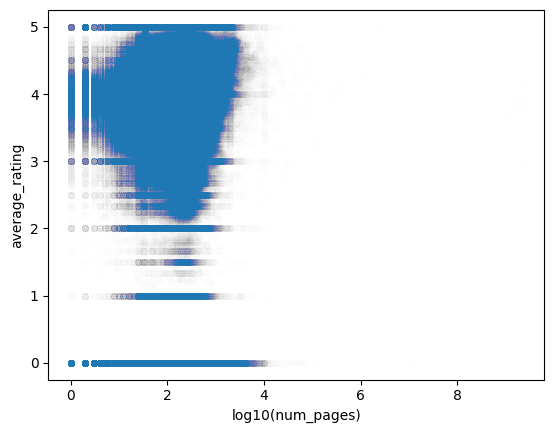

In [ ]:
books_df = processing.answer_rq_8_1(data_path)
books_df.plot.scatter(y='average_rating', x='log10(num_pages)', alpha = 0.002)


The scatterplot shows rather the opposite. Starting from 10^2.5 pages the average ratings are increasing with increasing number of pages and concentrating around 4.5.

Considering only the books with up to 10^2.5 pages, we see that the variance in the average rating increases and the mean seems to decrease.

#### ad 2.
Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

After removing the books where no language is given we group the books by english or non-english. When done this we perform a Kolmogorov-Smirnov-Test to compare the distribution of their average-rate (:=average-ratings).

We divided them into english, non-english and no-languages. The first and the latter we defined explicitly the one in the middle is defined to be the rest.

In [ ]:
english_languages = {'en',
 'en-CA',
 'en-GB',
 'en-IN',
 'en-US',
 'eng',
 'enm'}
no_languages = {'',
 '--',
 'Select...',}

In [ ]:
books_df, grouped_df = processing.get_eng_vs_non_eng(data_path, no_languages)
grouped_df

The process lasted approximately 588.52 seconds.


,average_rating
en,
False,"[3.74, 3.93, 3.86, 3.99, 3.9, 3.28000000000000..."
True,"[4.5, 4.48, 4.43, 4.57, 4.5600000000000005, 4...."


In [ ]:
# now performing the kolmogorov-smirnov-test to check equality of the two distributions:
pval = processing.perform_ks2s_test_and_interprete(grouped_df.loc[False,'average_rating'], grouped_df.loc[True,'average_rating'], alpha=0.05)

assuming a test-level of alpha = 0.05
Since the pvalue is approximately 0.000000 , i.e. less than or equal to alpha, 
there's significance for a difference in the analyzed distributions.


#### ad 3.
About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

Next we provide some (helpful) statistics and a boxplot. First we want to describe a boxplot as it is created by the method we use:

"The box extends from the first quartile (Q1) to the third quartile (Q3) of the data, with a line at the median. The whiskers extend from the box to the farthest data point lying within 1.5x the inter-quartile range (IQR) from the box. Flier points are those past the end of the whiskers."

source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

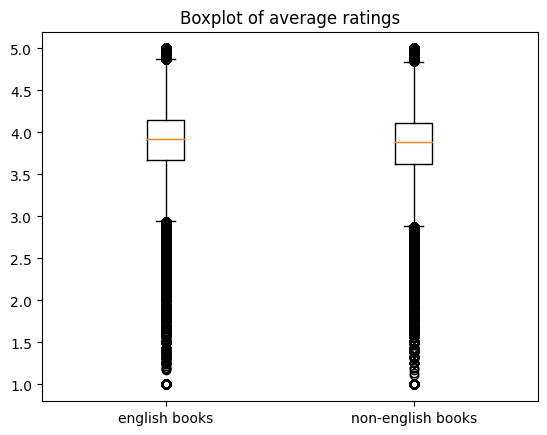

,ratings_count,average_rating
count,2.559436e+06,2.559436e+06
mean,3.659237e+04,3.870687e+00
std,2.339213e+05,4.700350e-01
min,1.000000e+00,1.000000e+00
25%,1.900000e+01,3.650000e+00
50%,2.100000e+02,3.910000e+00
75%,3.120250e+03,4.130000e+00
max,7.400639e+06,5.000000e+00


In [ ]:
from matplotlib import pyplot as plt
plt.title("Boxplot of average ratings")
plt.boxplot([grouped_df.loc[True,'average_rating'], grouped_df.loc[False,'average_rating']], labels =["english books","non-english books"])
plt.show()
books_df.describe()

Next we see the **mode** of ratings_count, average_rating, language and en."
The mode is probably only useful for "langauge" and "en" since these are non-metric, even categorical.


In [ ]:
books_df.mode()


,ratings_count,average_rating,language,en
0,1,4.0,eng,True


#### ad 4.
It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

The process lasted approximately 18.33 seconds.
We consider the rooted dataset since here the impact of outliers is lowered.
slope is 1.0064483337654362
intercept is 218.6714909962816
R-squared-Coefficient is 0.48201227257060164
Since the slope is significantly greater than zero 
we see that the more fans an author has the more text_reviews he has. 
Hence we can refuse the stated claim that fans of authors with more fans would be lazier. 
The R-squared-Coefficient is with approximately 0.48
is low. Hence the model does explain only little of the seen variance.


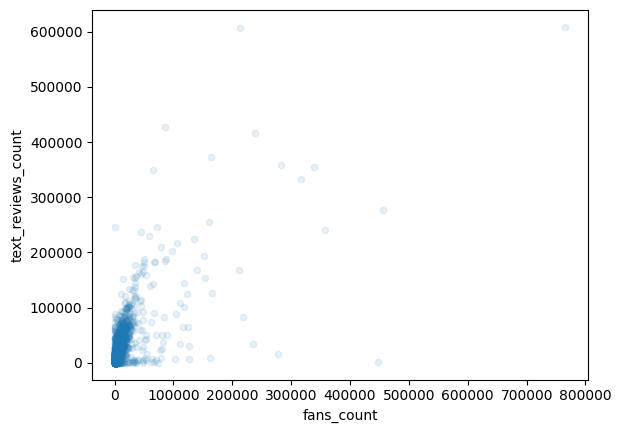

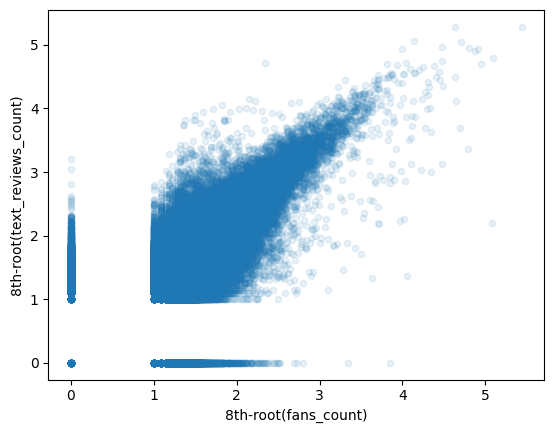

In [ ]:
books_df = None # to free some memory
authors_df = processing.get_data_on_lazyness(data_path)
authors_df.plot.scatter(x='fans_count', y='text_reviews_count', alpha = 0.1)
authors_df.plot.scatter(x='8th-root(fans_count)', y='8th-root(text_reviews_count)', alpha = 0.1)
model, score = processing.perform_lin_regression(authors_df, 'fans_count', 'text_reviews_count'  )
print('We consider the rooted dataset since here the impact of outliers is lowered.')
processing.interprete_lin_regression(model,score)

#### ad 5.
Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

##### Hypothesis testing:
The alternative is (if possible) the claim we want to confirm. However sometimes it is not possible to choose what we want to claim as the alternative. For example if we are testing "theta $=$ 0" vs. "theta $\neq$ 0" often it is only possible to choose "theta==0" as the hypothesis.

Whenever we test hypotheses we need to determine a significance level, often called alpha, which determines the highest acceptable error of 1st kind, to determine if there's evidence for the alternative or not.

###### (non-)parametric tests:
Parametric tests assume that the distribution of data is known up to a paramter $\theta \in \mathbb{R}^d$ for some $d \in \mathbb{N}$. Given that we know the distribution (with high probability) we should use these since they are more appropriate for our data.

However if we don't know the distribution we should go for nonparametric tests, since these do not make assumptions on the distribution of the data. With less requirements for a tests one naturally gets less out of it, but few is better than nothing or something wrong.

###### Some useful tests are...
- fisher and chi-square for independence of binary resp. categorical variables
- kolmogorov-smirnov or mann-whitney-u to compare two unknown distributions
- regression tests
  - (multiple) linear regression
  - logistic regression
  - polynomial regression


## Command Line Question
1. Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]
2. Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

In [ ]:
# commandline_original.sh
# Human Code

#!/bin/bash

data="series.json"

top_count=5

series=()
while read -r line; do
    id=$(echo "$line" | jq -r '.id')
    title=$(echo "$line" | jq -r '.title')
    book_count=$(echo "$line" | jq -r '.works | map(.books_count | tonumber) | add')

    if [ -n "$id" ] && [ -n "$title" ] && [ -n "$book_count" ]; then
        series+=("$id|$title|$book_count")
    fi
done < "$data"

sorted_series=($(echo "${series[@]}" | tr ' ' '\n' | sort -t "|" -k3,3nr | head -n $top_count))

echo "id    title                                total_books_count"

for line in "${sorted_series[@]}"; do
    IFS="|" read -r id title book_count <<< "$line"
    printf "%-6s%-35s%-6s\n" "$id" "$title" "$book_count"
done


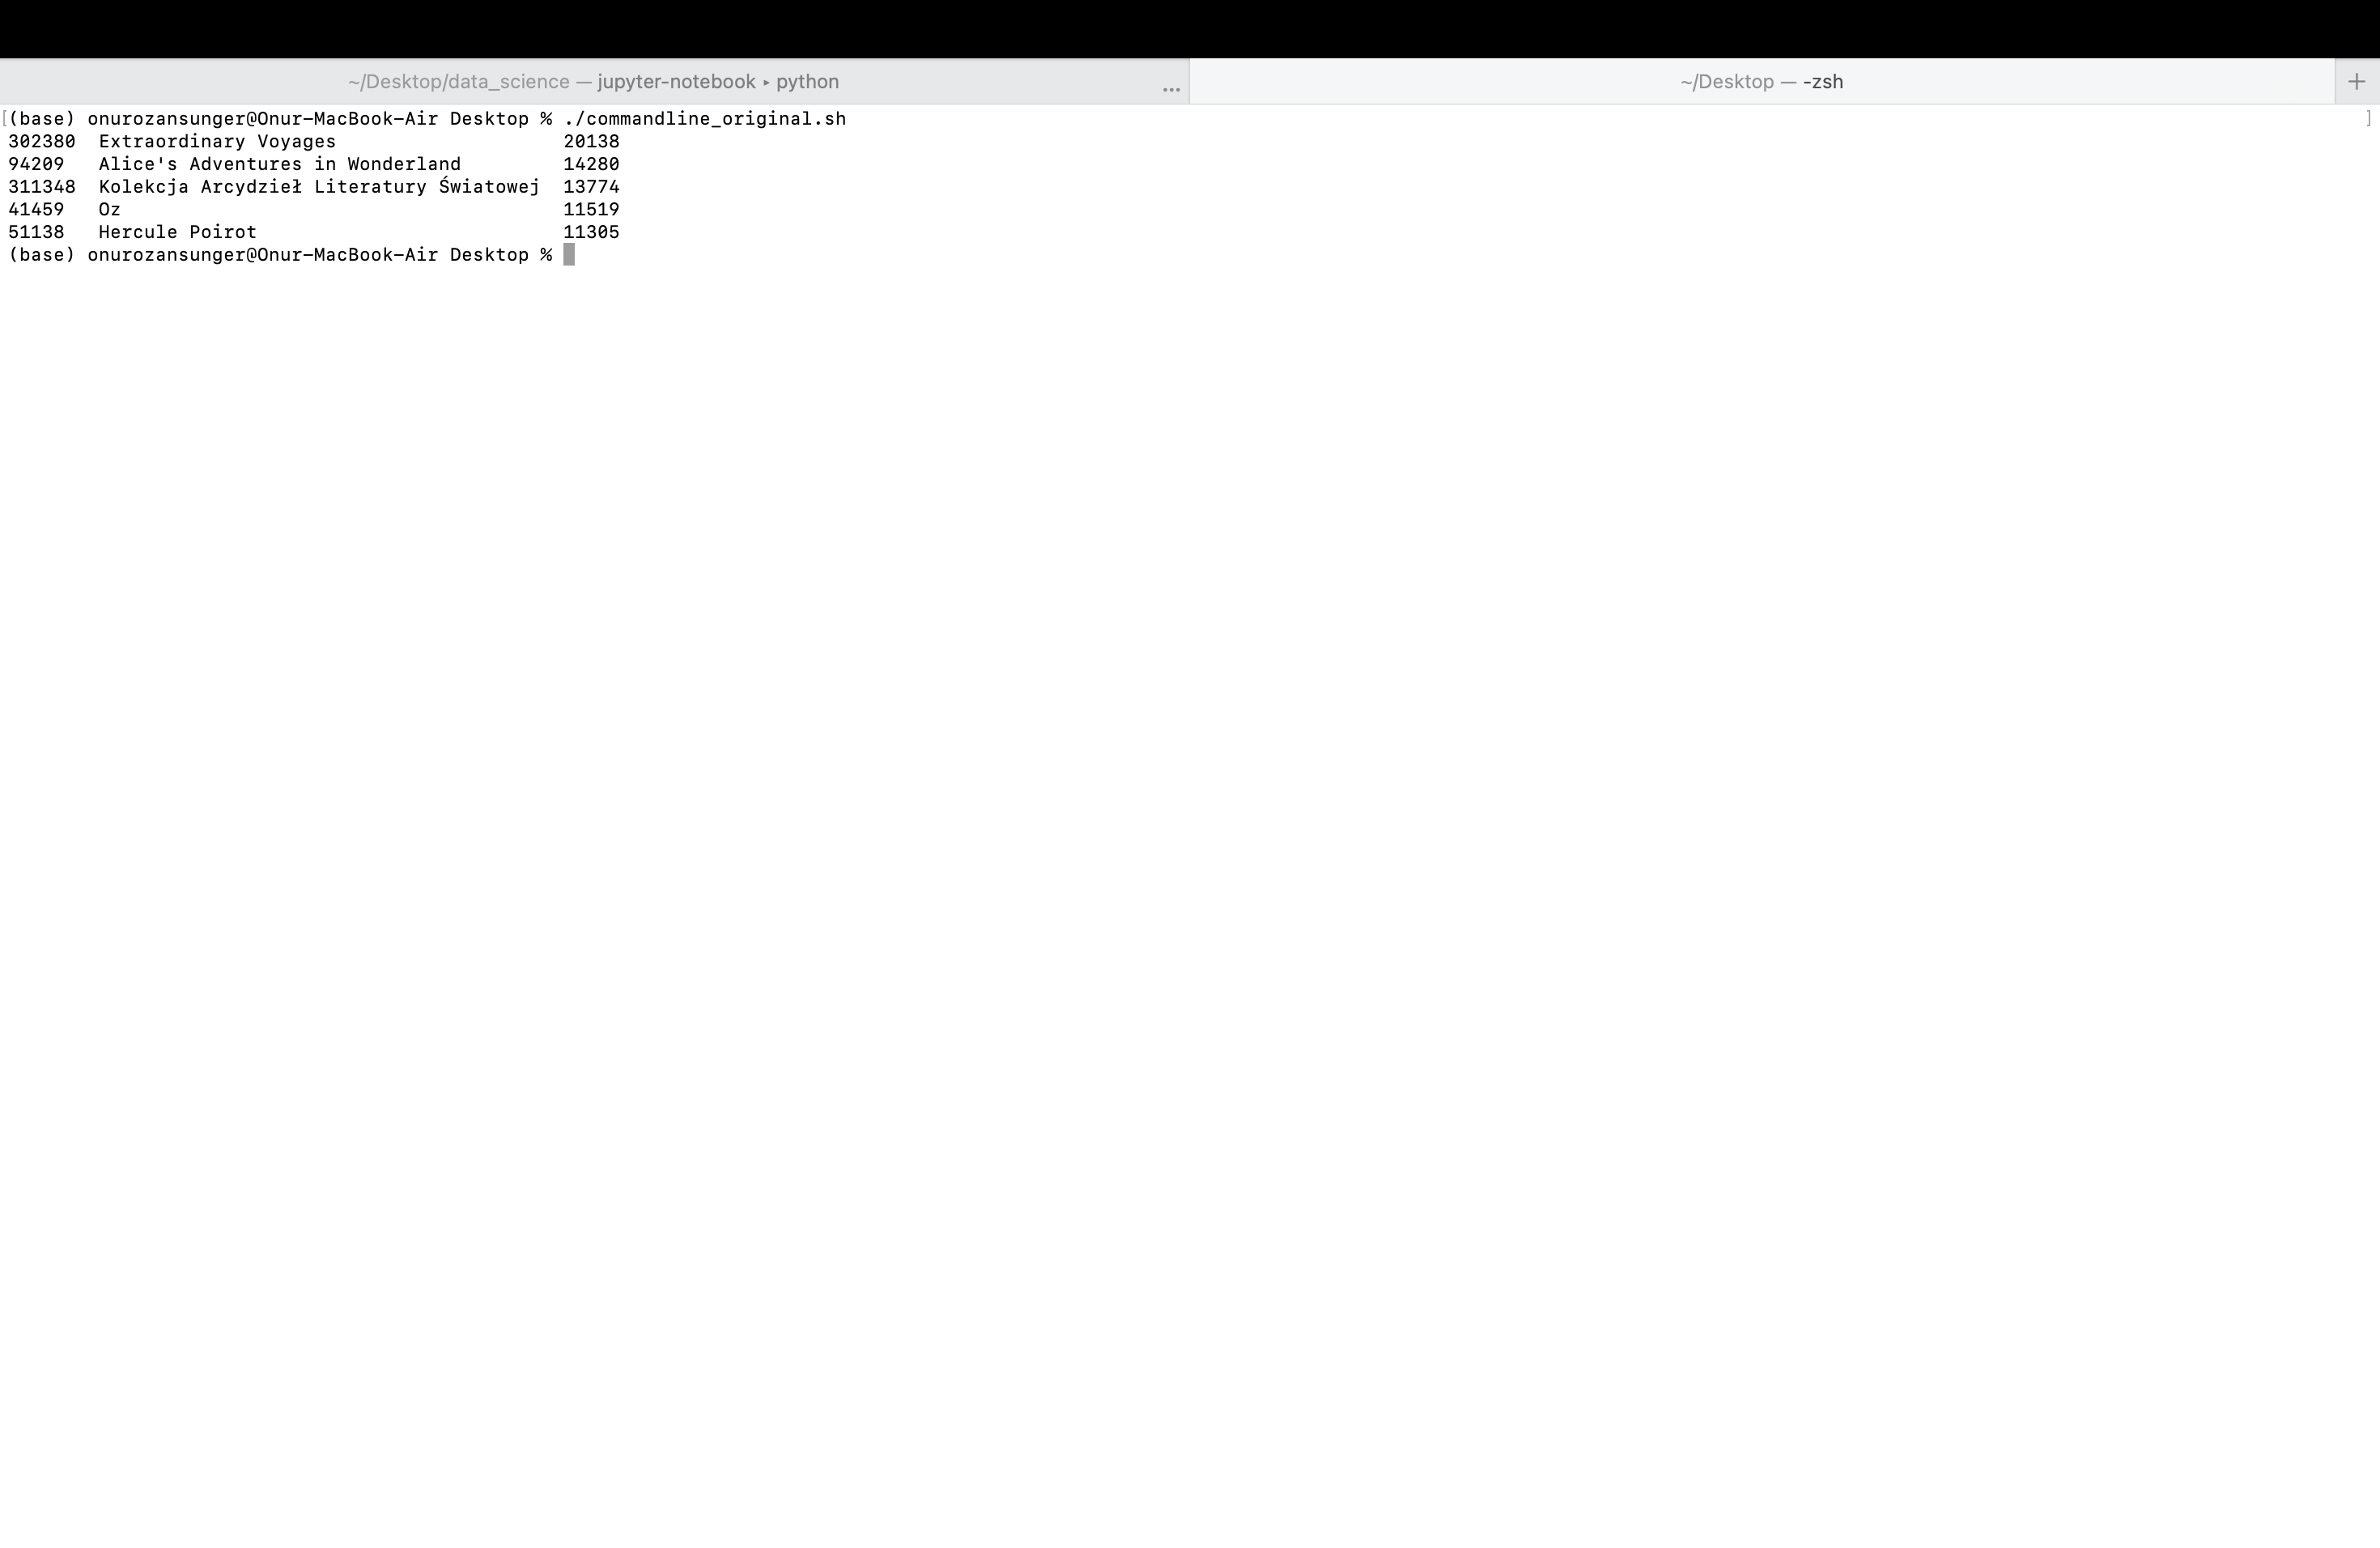

In [ ]:
# commandline_LLM.sh
# GPT Code

#!/bin/bash
data="series.json"
jq -r '.id as $id | .title as $title | (.works | map(.books_count | tonumber) | add) as $total_books_count | "\($id)\t\($title)\t\($total_books_count)"' "$data" | sort -t$'\t' -k3,3nr | head -n 5 | column -t -s $'\t'

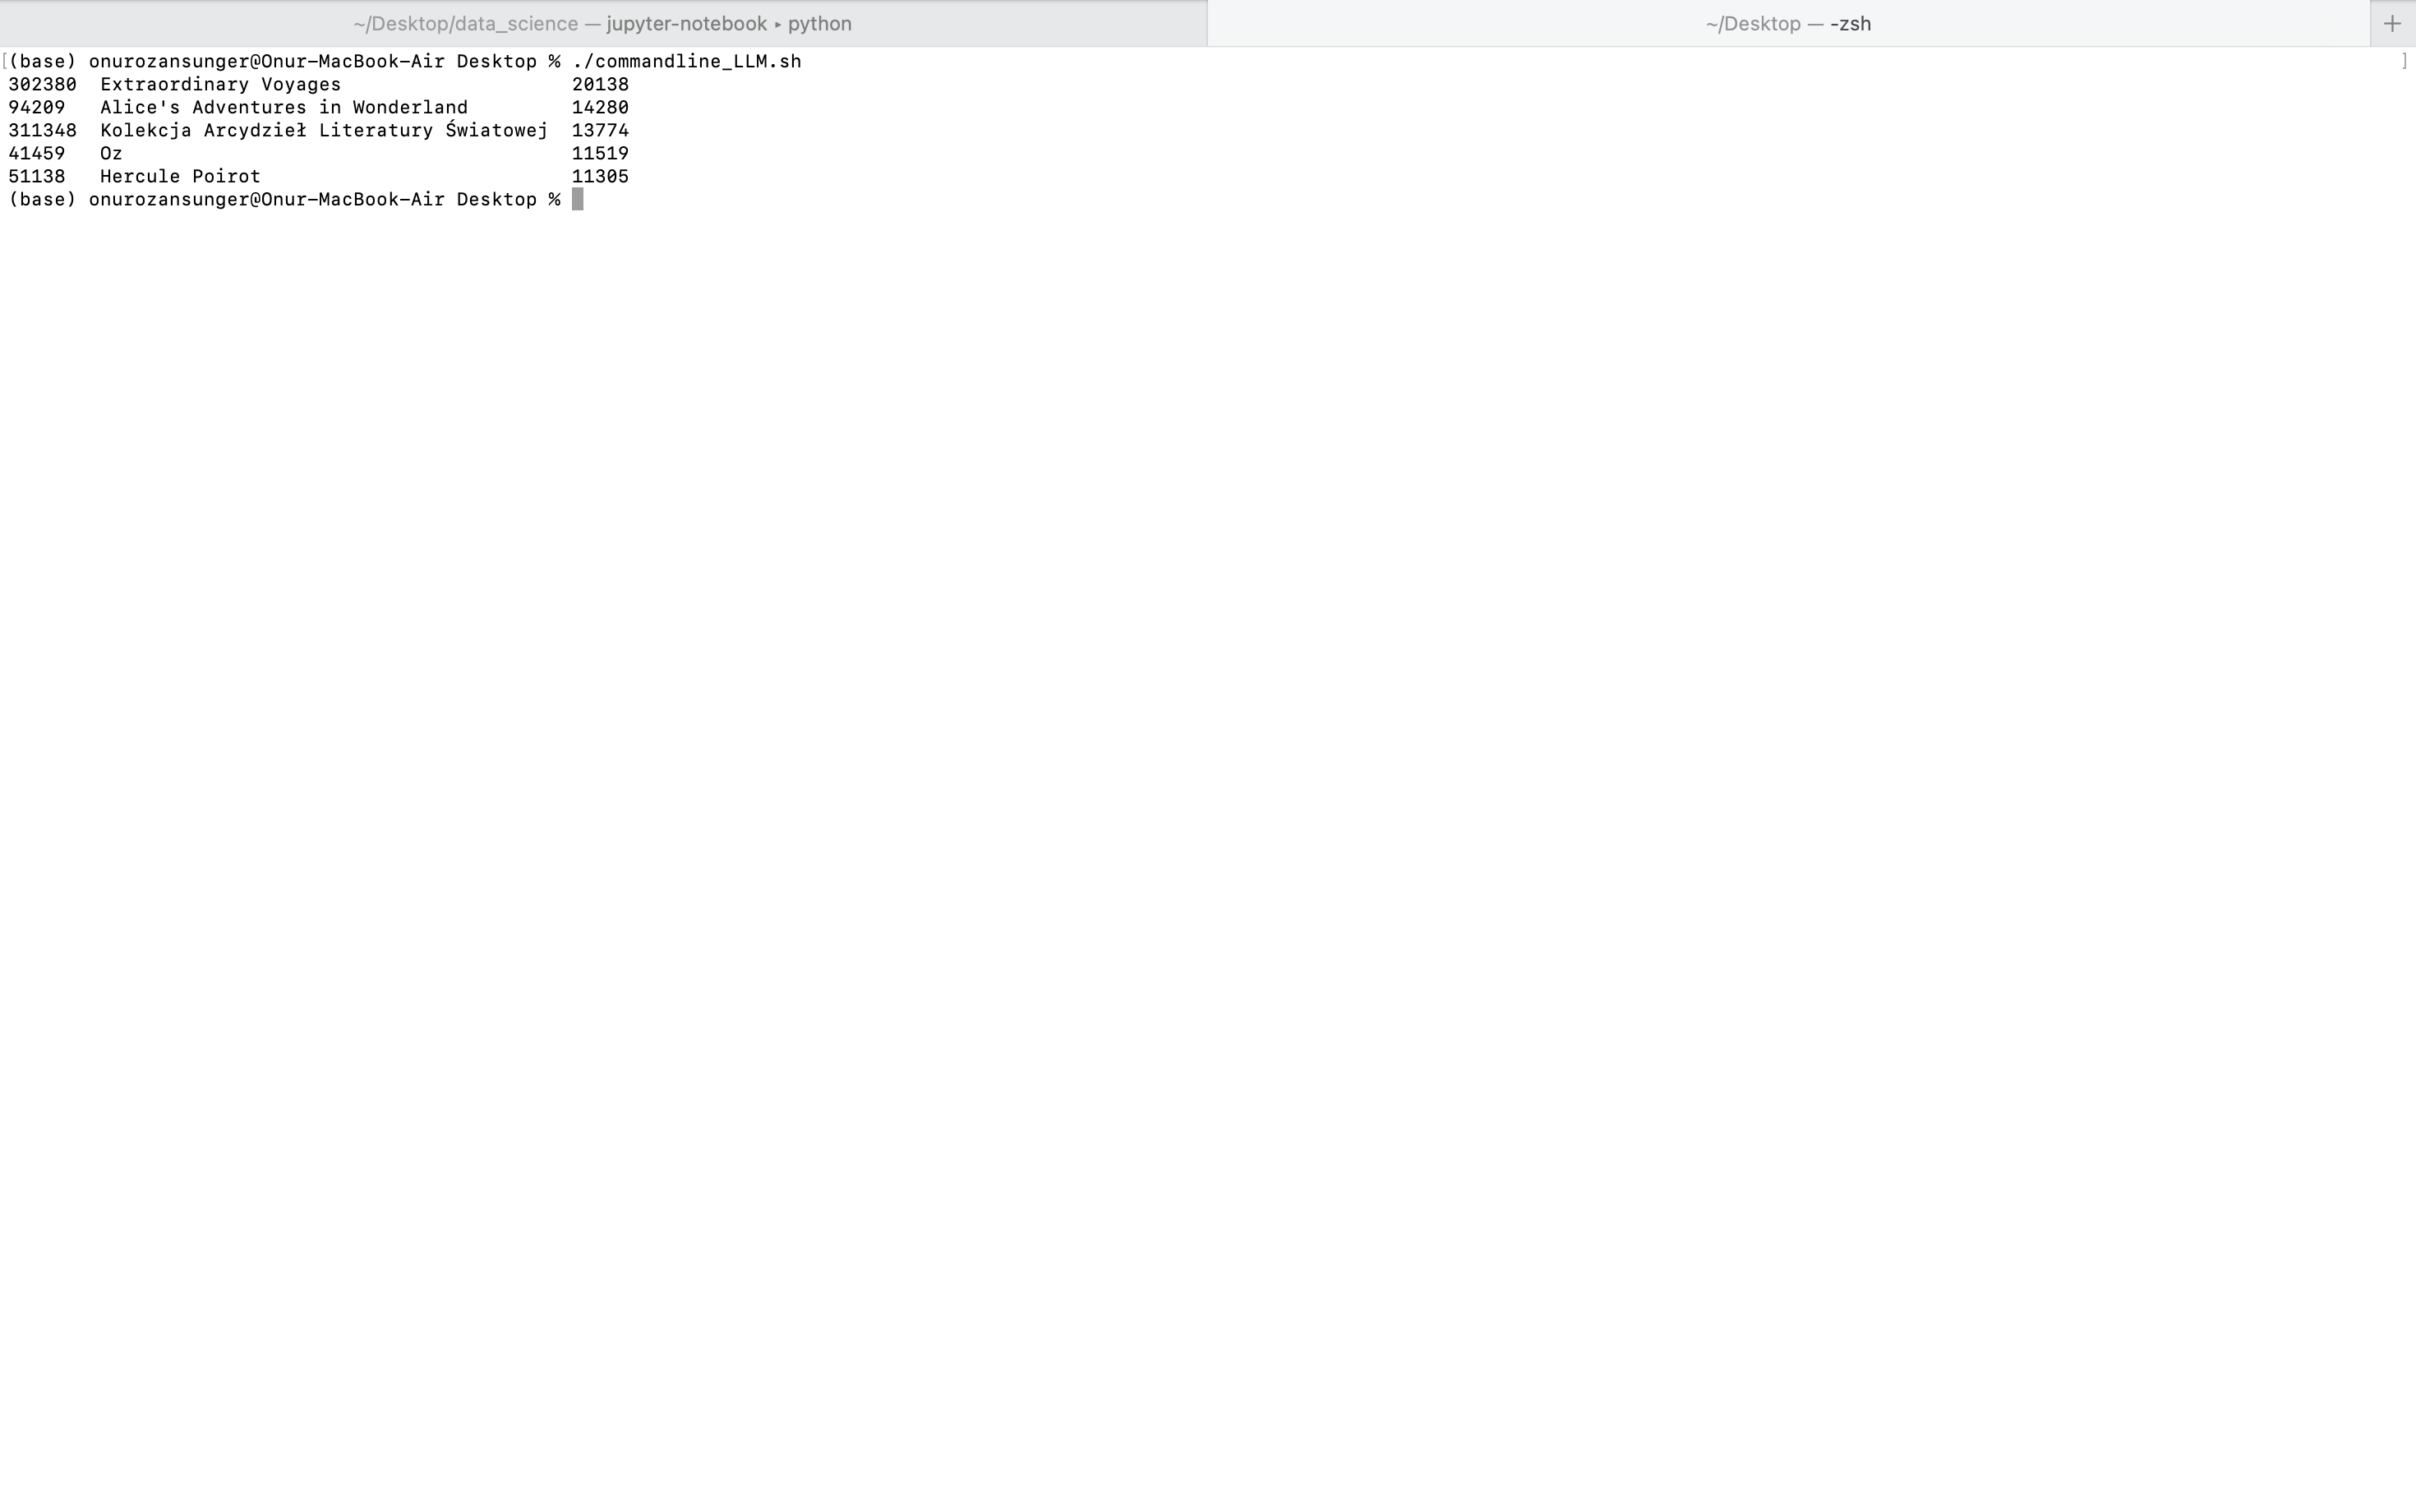

# AWS Question (AWSQ)

## EC2 Configuration

* Istance type: t2.micro

* Operating system: Ubuntu 22.04 from AMI

* Other configuration settings kept as by default

## Group security rules

* Inboud rule: ssh, port 22

* Inbound rule: TCP, port 8088

## Commands to connect to the EC2 istance and run the script

* From the local terminal to connect to the EC2 istance with ssh: ssh -i “my_key.pem” ubuntu@IPv4_DNS

* From the local terminal to copying the list.json file on the EC2 istance: scp -i “My_key.pem” list.json ubuntu@IPv4_DNS:~/

* From the EC2 istance terminal to open a jupyter notebook server: jupyter notebook --no-browser

* From the local terminal to create a link: ssh -L 8088:localhost:8888 -i “My_key.pem” ubuntu@IPv4_DNS

* from the browser to open the jupyter notebook server running on the EC2 istance: http ://localhost:8088

## Local machine

In [1]:
#importing usefull libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
import random
import time

In [2]:
#loading the data fro list.json file
datafile = "/media/francesco/DATA/datasets/list.json"

#defining the cunk size
chunk_size = 100

#reading the file
data = pd.read_json(datafile, lines=True, chunksize=chunk_size, nrows=None)

#inizialization of a pandas series and of a list
s_tot_tags = pd.Series()
l = []

#starting time count
start_time = time.perf_counter()

#chunk loop
for chunk in data:
    
    #inserting data from the chunk in a pandas dataframe 
    df = pd.DataFrame(chunk)
    
    #inizialization of list
    tags = []
    
    #rows loop
    for i in df.index:
        
        #appending tags
        if type(df.loc[i,'tags']) ==  type(l):
            for e in df.loc[i,'tags']:
                tags.append(str(e))
    
    #making a series with the tags list
    s_tags = pd.Series(tags)
    
    #adding to the series
    s_tot_tags = pd.concat([s_tot_tags,s_tags.value_counts()])
    
#summing along the same tags
first_five = s_tot_tags.groupby(level=0).sum()

#sorting
first_five = first_five.sort_values(ascending=False)[:5]

#stop time count
end_time = time.perf_counter()

#calculating running time
delta_time = end_time-start_time


In [3]:
#labeling the series and printing the results
first_five = first_five.rename_axis("Tags")
first_five = pd.DataFrame(first_five)
first_five.columns = ['#usage']
print(first_five)
print('\n\n')
print('The running time using the local machine is: ',delta_time)

                 #usage
Tags                   
romance            6001
fiction            5291
young-adult        5016
fantasy            3666
science-fiction    2779



The running time using the local machine is:  33.801238152000224


## AWS EC2 istance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import random
import time

In [2]:
datafile = "list.json"
chunk_size = 100

data = pd.read_json(datafile, lines=True, chunksize=chunk_size, nrows=None)
s_tot_tags = pd.Series()
l = []

start_time = time.perf_counter()
for chunk in data:
    df = pd.DataFrame(chunk)
    tags = []
    
    for i in df.index:
        if type(df.loc[i,'tags']) ==  type(l):
            for e in df.loc[i,'tags']:
                tags.append(str(e))
    
    s_tags = pd.Series(tags)
    s_tot_tags = pd.concat([s_tot_tags,s_tags.value_counts()])
    
first_five = s_tot_tags.groupby(level=0).sum()
first_five = first_five.sort_values(ascending=False)[:5]
end_time = time.perf_counter()

delta_time = end_time-start_time

/tmp/ipykernel_2332/1824686116.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s_tot_tags = pd.concat([s_tot_tags,s_tags.value_counts()])


In [3]:
first_five = first_five.rename_axis("Tags")
first_five = pd.DataFrame(first_five)
first_five.columns = ['#usage']
print(first_five)
print('\n\n')
print('The running time using the local machine is: ',delta_time)

                 #usage
Tags                   
romance            6001
fiction            5291
young-adult        5016
fantasy            3666
science-fiction    2779



The running time using the local machine is:  47.87413882999954


* ## Final tables

| tag            | #usage  | 
| --------       | ------- | 
| romance        | 6001    | 
| fiction        | 5291    | 
| young-adult    | 5016    | 
| fantasy        | 3666    |
|science-fiction | 2779    |

| machine        | running time [s] | 
| --------       | -------          | 
| local          | 33.801           | 
| EC2 istance    | 47.874           | 

The running time of the local machine is shorter then the running time of the EC2 istance.

## Algorithmic Question
1. Implement a code to answer the problem on https://github.com/Sapienza-University-Rome/ADM/tree/master/2023/Homework_2 . 
2. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.
3. Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

### ad 1.
We solve the task by implementing a dictionary. The dictionary's keys are the book IDs. The value of each book ID represents its position.

If the boss asks for a book by "? N" we can deliver the minimal number of books to be popped in constant time (calculation follows in 2.).

The time to create the shelf is of course O(n). But this is the time which is needed for the input. Hence irrelevant.

Further we supply a method to visualize the library in an ordinary list.

In [ ]:
# visualization of the shelf
visualizeIt = False
def visualizeShelf(my_dict):
    """
    takes a dictionary consisting of integer keys and integers values.
    Returns a list of the keys where the keys are sorted by their values.
    """
    return [ k for k,v in sorted(my_dict.items(), key=lambda x: x[1])]

In [ ]:
n = int(input())
shelf = {}
leftmost = -1 # next free position on the left
rightmost = 0 # next free position on the right
for _ in range(n):
    command, book_id = input().split()
    if command == "L":
        shelf[int(book_id)]=leftmost
        leftmost -= 1
        continue
    if command == "R":
        shelf[int(book_id)]=rightmost
        rightmost += 1
        continue
    if command == "?":
        if visualizeIt:
            print('current shelf looks like:', visualizeShelf(shelf))
        print(min( shelf[int(book_id)] - (leftmost + 1) , (rightmost - 1) - shelf[int(book_id)]))




1
1


#### Ad 2.
*We are considering "Is this correct?" referring to the answer of ChatGPT and not the code itself. Furhter we are considering visualizeIt to be **false**.*

**Question asked to ChatGPT:**

Estimate the time complexity of the following code, especially for the "?"-Command and in the "?"-case respectively: [above code inserted]

**Answer by ChatGPT:**

The time complexity of the provided code is as follows:

- For the "L" and "R" commands, the time complexity is **O(1)**. This is because adding an element to a dictionary in Python is a constant time operation.

- For the "?" command, the time complexity is also **O(1)**. This is because looking up an element in a Python dictionary is a constant time operation, and the mathematical operations (like subtraction and the min function) are also constant time operations.

So overall, the time complexity of the code is **O(n)**, where **n** is the number of commands to be executed. This is due to the fact that each command is executed once in a for loop. Each command has a constant time complexity, so the total time complexity is linear with respect to the number of commands.

**Resumé**

The answer given by ChatGPT is correct. We can calculate it:
Before the first (and only) loop there are only constant-time-operations
- declaring variables, 
- initiating an empty dictionary, 
- taking one line of input.
In the first (and only) loop there are again only constant-time-operations:
- comparing two characters and evaluating the truth value,
- writing a value and a key to a dictionary, 
- updating integers,
- performing a "continue" (i.e. jump in the code),
- looking up a value in dictionary (! this is done by hashing and hence constant!)
- adding and substracting a finite and constant number of integers
- calculating the minimum of a finite and constant number of integers

Since every computation inside the loop needs only constant time and there are finitely many computations inside the loop, the loop itself has time-complexity O(n), where n is the number of iterations of the loop or the number of incoming commands, respectively.
Since before the loop there are only constant-timte-computations and there is no code after the loop we have a time-complexity for the whole code of O(n).

As said above by hashing it is possible to access a value of a given key in a dictionary in constant time. Hence the ?-command is performed in constant time. 








### ad 3.
**Concerning the whole Code:**

Given that the way the input is supplied is fixed the time complexity of the whole code is optimal, since its time-complexity is determined by the way the input is supplied.
If the way the input is supplied is not fixed one could alternatively think about providing the input in one line. Then one could split, which can be done faster than in O(n). For example consider a string with n entries, each separated by a comma. Then similiar to a binary-tree it could be split easily (parallely) in O(log(n)). If the input could be directly transformed into a dictionary even faster input is thinkable.

**Concerning the "?"-command**

By the choice of our model of time-complexity (where reading an integer takes constant time (as well as writing an integer)), performing the "?"-command in O(1) is optimal.



